# Inspection of variables after Full Selection

**_must run with dfs created with the full selection_**

This notebook inspects the selection after the full selection


- inspect cut variable distributions, compare data vs. MC
- optimize PID cuts in favor of purity over efficiency
- evalutes reconstruction resolution of kinematic variables to measure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm

# local imports
sys.path.append('../../')
from variable_configs import VariableConfig
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from matplotlib.offsetbox import AnchoredOffsetbox, DrawingArea, HPacker, VPacker, TextArea
from matplotlib.legend import Legend

In [2]:
def match_trkdf_to_slcdf(trkdf, slcdf):
    # trkdf: df to match
    # slcdf: df to match to
    matched_trkdf = trkdf.reset_index(level=[3]).loc[slcdf.index].reset_index().set_index(trkdf.index.names)
    return matched_trkdf


In [3]:
def mag3d(df1, df2):
    return np.sqrt((df1.x - df2.x)**2 + (df1.y - df2.y)**2 + (df1.z - df2.z)**2)

In [4]:
save_fig = False
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/full_selection"

# Load dfs

In [5]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"
## -- MC 
mc_file = path.join(file_dir, "MC_bnb_cosmics_finalsel.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

## -- Data
data_file = path.join(file_dir, "Data_dev_sel.df")
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

## -- Intime Data
intime_file = path.join("/exp/sbnd/data/users/munjung/xsec/2025B", "Data_intime-2prong.df")
intime_split_df = pd.read_hdf(intime_file, key="split")
intime_n_split = get_n_split(intime_file)
print("intime_n_split: %d" %(intime_n_split))
print_keys(intime_file)

mc_n_split: 5
Keys: ['/evt_0', '/evt_1', '/evt_2', '/evt_3', '/evt_4', '/hdr_0', '/hdr_1', '/hdr_2', '/hdr_3', '/hdr_4', '/mcnu_0', '/mcnu_1', '/mcnu_2', '/mcnu_3', '/mcnu_4', '/split']
data_n_split: 2
Keys: ['/bnbpot_0', '/bnbpot_1', '/bnbpot_2', '/evt_0', '/evt_1', '/evt_2', '/hdr_0', '/hdr_1', '/hdr_2', '/split', '/trk_0', '/trk_1', '/trk_2']
intime_n_split: 1
Keys: ['/bnbpot_0', '/evt_0', '/hdr_0', '/split']


In [6]:
# concat dfs 
n_max_concat = 5

mc_keys2load = ['hdr', 'evt'] 
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']

data_keys2load = ['evt', 'hdr']
data_dfs = load_dfs(data_file, data_keys2load, n_max_concat=n_max_concat)
data_evt_df = data_dfs['evt']
data_hdr_df = data_dfs['hdr']

intime_keys2load = ['hdr', 'evt']
intime_dfs = load_dfs(intime_file, intime_keys2load, n_max_concat=n_max_concat)
intime_hdr_df = intime_dfs['hdr']
intime_evt_df = intime_dfs['evt']

In [7]:
## total pot - scale to data POT

# BNB data
data_tot_pot = data_hdr_df['pot'].sum()
print("data_tot_pot: %.3e" %(data_tot_pot))
pot_str = "5.98 $\\times 10^{18}$"
data_evt_df["pot_weight"] = np.ones(len(data_evt_df))
data_gates = data_hdr_df.nbnbinfo.sum()
print("data tot gates : %.3e" %(data_gates))

# BNB MC
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))
mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

# Intime Data
# intime_gates = intime_hdr.noffbeambnb.sum()
intime_gates = intime_hdr_df[intime_hdr_df['first_in_subrun'] == 1]['noffbeambnb'].sum()
print("intime cosmics data gates: {:.2e}".format(intime_gates))
f = 0.073
scale_intime_to_lightdata = (1-f)*data_gates/intime_gates
print("goal scale: {:.2f}".format(scale_intime_to_lightdata))
intime_evt_df["gates_weight"] = scale_intime_to_lightdata * np.ones(len(intime_evt_df))

data_tot_pot: 5.975e+18
data tot gates : 1.256e+06
mc_tot_pot: 5.856e+20
mc_pot_scale: 1.020e-02
intime cosmics data gates: 1.36e+08
goal scale: 0.01


# Plotter

In [24]:
nu_cosmics_labels = ["Cosmic", r"Out-FV $\nu$", r"FV $\nu$"]
# nu_cosmics_colors = ["#ED5564", "#FFCE54", "#A0D568"]
nu_cosmics_colors = ["gray", "C0", "C1"]

topology_labels = ["Cosmic", r"Out-FV $\nu$", r"FV other $\nu$", r"FV $\nu_{\mu}$ NC",  
                  r"FV $\nu_{\mu}$ CC Other", r"FV $\nu_{\mu}$ CC Np0$\pi$", r"FV $\nu_{\mu}$ CC 1p0$\pi$"]
topology_colors = ["gray", "sienna", "crimson", "darkgreen", 
                  "coral", "darkslateblue", "mediumslateblue"]

genie_labels = ["Cosmic", r"Out-FV $\nu$", r"FV $\nu$ Other", r"FV $\nu_{\mu}$ NC",
                r"FV $\nu_{\mu}$ CC Other", r"FV $\nu_{\mu}$ CC DIS",
                r"FV $\nu_{\mu}$ CC RES", r"FV $\nu_{\mu}$ CC MEC",
                r"FV $\nu_{\mu}$ CC QE"]
genie_colors = ["gray", "sienna", "crimson", "darkgreen",
                "#BFB17C", "#D88A3B", "#2c7c94",
                "#390C1E", "#9b5580"]

In [30]:
def hist_plot(type,
              evtdf, vardf, 
              vardf_data, var_intime,
              bins,
              plot_labels=["", "", ""],
              ratio = True,
              vline = None,
              approval="internal",
              save_fig=False, save_name=None): 

    assert len(evtdf) == len(vardf)

    tot_mc_count = len(evtdf)
    tot_data_count = len(vardf_data)

    if type == "nu_cosmics":
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv = IsNuInFV(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv]

    elif type == "topology":
        labels = topology_labels
        colors = topology_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif type == "genie":
        labels = genie_labels
        colors = genie_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        print("numu NC", cut_nu_infv_numu_nc.sum())
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]
        

    else:
        raise ValueError("Invalid type: %s, please choose between [nu_cosmics, topolgy, or genie]" % type)

    # --- Plot template
    if ratio:
        fig, axs = plt.subplots(2, 1, figsize=(8.5, 8), 
                               sharex=True, gridspec_kw={'height_ratios': [4, 1]})
        fig.subplots_adjust(hspace=0.05)
        ax = axs[0]
        ax_r = axs[1]
    else:
        fig, ax = plt.subplots()

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Data
    total_data, bins = np.histogram(vardf_data, bins=bins)
    data_err = np.sqrt(total_data)
    ax.errorbar(bin_centers, total_data, yerr=data_err, 
                fmt='o', color='black')  # error bars

    # --- MC
    # collect all MC + intime
    var_categ = [var_intime] + [vardf[i] for i in cuts]
    scale_mc = evtdf.pot_weight.unique()[0]
    # TODO:
    scale_intime = scale_intime_to_lightdata
    weights_categ = [scale_intime*np.ones_like(var_intime)] + [scale_mc*np.ones_like(vardf[i]) for i in cuts] 
    colors = ["silver"] + colors
    labels = ["Cosmic\n(In-time)"] + labels

    mc_stack, _, _ = ax.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                label=labels,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')


    # ---- MC stat err
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(var_categ, weights_categ):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)

    ax.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='dimgray',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        # label='MC Stat. Unc. ({})'.format(tot_mc_count)
        label='MC Stat. Unc. '
    )


    ax.set_xlim(bins[0], bins[-1])
    if ratio == False: # only plot xlabel if we're not plotting the ratio panel
        ax_r.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_title(plot_labels[2])

    if ratio:
        # MC stat err
        mc_stat_err_ratio = mc_stat_err / total_mc
        mc_content_ratio = total_mc / total_mc
        mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
        mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
        ax_r.bar(
            bin_centers,
            2*mc_stat_err_ratio,
            width=np.diff(bins),
            bottom=mc_content_ratio - mc_stat_err_ratio,
            facecolor='none',             # transparent fill
            edgecolor='dimgray',          # outline color of the hatching
            hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
            linewidth=0.0,
            label='MC Stat. Unc.'
        )

        # data/MC ratio err
        data_eylow, data_eyhigh = return_data_stat_err(total_data)

        data_ratio = total_data / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_r.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black')
                #   , label='Data')
                #   markersize=5, capsize=3, linewidth=1.5)
        
        # if highest value is greater than 2.0, set ylim to 2.0
        ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
        
        ax_r.grid(True)
        ax_r.minorticks_on()
        ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

        ax_r.set_xlabel(plot_labels[0])
        ax_r.set_ylabel("Data/MC")

        if np.max(data_ratio + data_ratio_eyhigh) > 2.0:
            ax_r.set_ylim(0., 2.0)

    # --- Legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels += ["Data ({})".format(tot_data_count), "MC Stat. Unc. "]
    leg = ax.legend(legend_labels, 
                    loc='upper left', 
                    fontsize=10, 
                    frameon=False, 
                    ncol=3, 
                    bbox_to_anchor=(0.015, 0.985))
    leg_height = leg.get_bbox_to_anchor().height
    max_data_with_err = np.max(total_data + data_eyhigh)
    # ax.set_ylim(0., 1.05 * max_data_with_err + leg_height)
    ax.set_ylim(0., 1.4 * max_data_with_err)

    if vline is not None:
        # Draw a vertical line from y=0 up to the max value of the histogram
        for v in vline:
            ymax = ax.get_ylim()[1]
            ax.vlines(x=v, ymin=0, ymax=ymax*0.75, color='red', linestyle='--')

    # --- approval textbox
    # decide if the distribution is tilted to the right or left
    n_firsthalf = np.sum(total_data[:len(bins)//2])
    n_secondhalf = np.sum(total_data[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        textloc_ha = 'right'
    else:
        textloc_x = 0.05
        textloc_ha = 'left'

    if approval == "internal":
        ax.text(textloc_x, 0.65, "SBND Internal", transform=ax.transAxes, 
                fontsize=14, color='rosybrown',
                ha=textloc_ha, va='top')

    elif approval == "preliminary":
        ax.text(textloc_x, 0.65, "SBND Preliminary", transform=ax.transAxes, 
                fontsize=14, color='gray',
                ha=textloc_ha, va='top')


    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    
    ret_dict = {"cuts": cuts}
    return ret_dict

In [31]:
def hist_plot_genie_sb(type,
              evtdf, vardf, 
              vardf_data, var_intime,
              bins,
              plot_labels=["", "", ""], legendloc="right",
              ratio = True,
              vline = None,
              approval="internal",
              save_fig=False, save_name=None): 

    assert len(evtdf) == len(vardf)

    tot_mc_count = len(evtdf)
    tot_data_count = len(vardf_data)

    # repeat later numu labels twice
    labels = genie_labels[:4] 
    for i in range(4, len(genie_labels)):
        labels += [genie_labels[i]] * 2
    colors = genie_colors[:4]
    for i in range(4, len(genie_colors)):
        colors += [genie_colors[i]] * 2
# 
    cut_cosmic = IsCosmic(evtdf)
    cut_nu_outfv = IsNuOutFV(evtdf)
    cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
    cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
    print("numu NC", cut_nu_infv_numu_nc.sum())
    # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
    # break down numu modes into signal and background
    cut_nu_infv_numu_othermode_s = IsNuInFV_NumuCC_OtherMode(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_othermode_b = IsNuInFV_NumuCC_OtherMode(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_dis_s = IsNuInFV_NumuCC_DIS(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_dis_b = IsNuInFV_NumuCC_DIS(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_res_s = IsNuInFV_NumuCC_RES(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_res_b = IsNuInFV_NumuCC_RES(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_mec_s = IsNuInFV_NumuCC_MEC(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_mec_b = IsNuInFV_NumuCC_MEC(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_qe_s = IsNuInFV_NumuCC_QE(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_qe_b = IsNuInFV_NumuCC_QE(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
            cut_nu_infv_numu_othermode_b, cut_nu_infv_numu_othermode_s,
            cut_nu_infv_numu_cc_dis_b, cut_nu_infv_numu_cc_dis_s,
            cut_nu_infv_numu_cc_res_b, cut_nu_infv_numu_cc_res_s,
            cut_nu_infv_numu_cc_mec_b, cut_nu_infv_numu_cc_mec_s,
            cut_nu_infv_numu_cc_qe_b, cut_nu_infv_numu_cc_qe_s]
        

    # --- Plot template
    if ratio:
        fig, axs = plt.subplots(2, 1, figsize=(8.5, 8), 
                               sharex=True, gridspec_kw={'height_ratios': [4, 1]})
        fig.subplots_adjust(hspace=0.05)
        ax = axs[0]
        ax_r = axs[1]
    else:
        fig, ax = plt.subplots()

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Data
    total_data, bins = np.histogram(vardf_data, bins=bins)
    data_err = np.sqrt(total_data)
    ax.errorbar(bin_centers, total_data, yerr=data_err, 
                fmt='o', color='black')  # error bars

    # --- MC
    # collect all MC + intime
    var_categ = [var_intime] + [vardf[i] for i in cuts]
    scale_mc = evtdf.pot_weight.unique()[0]
    # TODO:
    scale_intime = scale_intime_to_lightdata
    weights_categ = [scale_intime*np.ones_like(var_intime)] + [scale_mc*np.ones_like(vardf[i]) for i in cuts] 
    colors = ["silver"] + colors
    labels = ["Cosmic\n(In-time)"] + labels
    hatches = [None] * len(labels)
    for i in range(5, len(labels), 2):
        hatches[i] = '////'
    # hatches = ['*'] * len(colors)

    mc_stack, _, _ = ax.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                label=labels,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')

    # Switch to stacked bar plots using ax.bar for hatches
    bottom = np.zeros(len(bins) - 1)
    for i, (data, w, color, label, hatch) in enumerate(zip(var_categ, weights_categ, colors, labels, hatches)):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        ax.bar(
            bin_centers,
            hist_vals,
            width=np.diff(bins),
            bottom=bottom,
            color='none',
            hatch=hatch,
            edgecolor='white',
            linewidth=0.0,
            align='center'
        )
        bottom += hist_vals


    # ---- MC stat err
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(var_categ, weights_categ):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)

    ax.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='dimgray',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )


    ax.set_xlim(bins[0], bins[-1])
    if ratio == False: # only plot xlabel if we're not plotting the ratio panel
        ax_r.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_title(plot_labels[2])

    if ratio:
        # MC stat err
        mc_stat_err_ratio = mc_stat_err / total_mc
        mc_content_ratio = total_mc / total_mc
        mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
        mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
        ax_r.bar(
            bin_centers,
            2*mc_stat_err_ratio,
            width=np.diff(bins),
            bottom=mc_content_ratio - mc_stat_err_ratio,
            facecolor='none',             # transparent fill
            edgecolor='dimgray',          # outline color of the hatching
            hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
            linewidth=0.0,
            label='MC Stat. Unc.'
        )

        # data/MC ratio err
        data_eylow, data_eyhigh = return_data_stat_err(total_data)

        data_ratio = total_data / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_r.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black')
                #   , label='Data')
                #   markersize=5, capsize=3, linewidth=1.5)
        
        # if highest value is greater than 2.0, set ylim to 2.0
        ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
        
        ax_r.grid(True)
        ax_r.minorticks_on()
        ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

        ax_r.set_xlabel(plot_labels[0])
        ax_r.set_ylabel("Data/MC")

        if np.max(data_ratio + data_ratio_eyhigh) > 2.0:
            ax_r.set_ylim(0., 2.0)


    # --- Legend
    # dummy plot for legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = []
    for lidx in range(5):
        legend_labels.append("{}\n({:0.1f}%/{:0.1f}%)".format(genie_labels[::-1][lidx], fractions[::-1][lidx*2], fractions[::-1][lidx*2+1]))
    for label, frac in zip(genie_labels[::-1][5:], fractions[::-1][10:]):
        legend_labels.append("{}\n({:0.1f}%)".format(label, frac))
    legend_labels += ["Cosmic (In-time)\n({:0.1f}%)".format(fractions[0])]
    legend_labels += ["Data\n({})".format(tot_data_count), "MC Stat. Unc."]

    # Set up legend handles with matching colors
    genie_colors_reversed = genie_colors[::-1]
    genie_labels_reversed = genie_labels[::-1]

    # Handles for the first 5 (with two fractions)
    handles = []
    for lidx in range(5):
        handles.append(Patch(facecolor=genie_colors_reversed[lidx], edgecolor='none'))
    # Handles for the rest of the genie categories (single fraction)
    for cidx in range(5, len(genie_labels_reversed)):
        handles.append(Patch(facecolor=genie_colors_reversed[cidx], edgecolor='none'))
    # Cosmic (In-time) color: assumed to be the last color in genie_colors
    handles.append(Patch(facecolor="silver", edgecolor='none'))
    # Data: black marker
    handles.append(Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=7, label='Data'))
    # MC Stat. Unc.: hatched box, gray edge, no fill
    handles.append(Patch(facecolor='none', edgecolor='dimgray', hatch='xxxx', linewidth=0, label='MC Stat. Unc.'))

    leg = ax.legend(handles, legend_labels, 
                    loc='upper left', 
                    fontsize=10, 
                    frameon=False, 
                    ncol=4, 
                    bbox_to_anchor=(0.015, 0.995))
    leg_height = leg.get_bbox_to_anchor().height
    max_data_with_err = np.max(total_data + data_eyhigh)
    ax.set_ylim(0., 1.4 * max_data_with_err)

    if vline is not None:
        for v in vline:
            ymax = ax.get_ylim()[1]
            ax.vlines(x=v, ymin=0, ymax=ymax*0.7, color='red', linestyle='--')

    # --- "SBND Preliminary" textbox
    # decide if the distribution is tilted to the right or left
    n_firsthalf = np.sum(total_data[:len(bins)//2])
    n_secondhalf = np.sum(total_data[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        ha = 'right'
    else:
        textloc_x = 0.05
        ha = 'left'

    if approval == "internal":
        ax.text(textloc_x, 0.65, "SBND Internal", transform=ax.transAxes, 
                fontsize=14, color='rosybrown',
                ha=ha, va='top')

    elif approval == "preliminary":
        ax.text(textloc_x, 0.65, "SBND Preliminary", transform=ax.transAxes, 
                fontsize=14, color='gray',
                ha=ha, va='top')

    # separate legend box with S / B hatches
    example_signal = Patch(facecolor="black", edgecolor='white', label='Signal')
    example_background = Patch(facecolor="black", edgecolor='white', hatch='////', linewidth=0, label='Background')
    if legendloc == "left":
        box_ax = ax.inset_axes([0.15, 0.5, 0.13, 0.13], transform=ax.transAxes)
    elif legendloc == "right":
        box_ax = ax.inset_axes([0.7, 0.5, 0.13, 0.13], transform=ax.transAxes)
    box_ax.axis('off')
    mini_legend = Legend(
        box_ax,
        handles=[example_signal, example_background],
        labels=['Signal', 'Background'],
        loc='center',
        fontsize=10,
        frameon=False,
        borderpad=0.7,
        handlelength=2,
        handleheight=1.5,
        ncol=2,
        fancybox=True,
        framealpha=1.0
    )
    box_ax.add_artist(mini_legend)

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    
    ret_dict = {"cuts": cuts}
    return ret_dict

In [11]:
def bar_plot(type,
             evtdf,
             plot_labels=["", "", ""], 
             save_fig=False, save_name=None): #, scale, stage):

    if type == "nu_cosmics":
        ncateg = 3
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_intfv = IsNu(evtdf) & InFV(evtdf.slc.truth.position)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_intfv]

    elif type == "topology":
        ncateg = 7
        labels = topology_labels
        colors = topology_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)

        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif type == "genie":
        ncateg = 9
        labels = genie_labels
        colors = genie_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]

    else:
        raise ValueError("Invalid type: %s, please choose between [nu_cosmics, topolgy, or genie]" % type)


    fig, ax = plt.subplots(figsize = (6, ncateg*0.6))

    scale = evtdf.pot_weight.unique()[0]
    size = [scale*len(evtdf[i]) for i in cuts]
    # size = []

    # # make sure that the categories don't overlap
    # for i in range(len(cuts)):
    #     for j in range(i+1, len(cuts)):
    #         if (cuts[i] & cuts[j]).sum() > 0:
    #             print("Categories overlap:", labels[i], labels[j])
    # # and check if the categories cover all events
    # if not np.array(size).sum() == len(evtdf):
    #     print("Categories do not cover all events")
    #     print("Total events:", len(evtdf))
    #     print("Sum of categories:", np.array(size).sum())

    bars = plt.barh(labels, size, align='center', color = colors)
    tot_count = np.array(size).sum()
    
    perc_list = []
    for bar in bars:
        width = bar.get_width()
        label_y_pos = bar.get_y() + bar.get_height() / 2
        perc = 100*(width+0.)/(tot_count+0.)
        ax.text(width+1, label_y_pos, s= ("%0.2f"%(100*(width+0.)/(tot_count+0.)) + "%"), va='center')
        perc_list.append(perc)

    plt.xlabel(plot_labels[0])
    plt.xlim(0, 1.12 * np.max(size))

    if save_fig:
        plt.savefig(save_name, bbox_inches="tight")

    ret_dict = {"cuts": cuts,
                "perc_list": perc_list}
    return ret_dict

In [32]:
def hist_plot_pdg_breakdown(
              trkdf, vardf, 
              vardf_data, 
              bins,
              plot_labels=["", "", ""],
              ratio = True,
              vline = None,
              save_fig=False, save_name=None): 

    assert len(trkdf) == len(vardf)

    tot_mc_count = len(trkdf)
    tot_data_count = len(vardf_data)

    labels = ["Muon", "Pion", "Proton", "Electron", "Photon", "Other"]
    colors = ["blue", "green", "red", "purple", "orange", "gray"]

    cut_muon = (np.abs(trkdf.pfp.trk.truth.p.pdg) == 13)
    cut_pion = (np.abs(trkdf.pfp.trk.truth.p.pdg) == 211)
    cut_proton = (np.abs(trkdf.pfp.trk.truth.p.pdg) == 2212)
    cut_electron = (np.abs(trkdf.pfp.trk.truth.p.pdg) == 11)
    cut_photon = (np.abs(trkdf.pfp.trk.truth.p.pdg) == 22)
    cut_other = ~cut_muon & ~cut_pion & ~cut_proton & ~cut_electron & ~cut_photon

    cuts = [cut_muon, cut_pion, cut_proton, cut_electron, cut_photon, cut_other]

    # --- Plot template
    if ratio:
        fig, axs = plt.subplots(2, 1, figsize=(8.5, 8), 
                               sharex=True, gridspec_kw={'height_ratios': [4, 1]})
        fig.subplots_adjust(hspace=0.05)
        ax = axs[0]
        ax_r = axs[1]
    else:
        fig, ax = plt.subplots()

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Data
    total_data, bins = np.histogram(vardf_data, bins=bins)
    data_err = np.sqrt(total_data)
    ax.errorbar(bin_centers, total_data, yerr=data_err, 
                fmt='o', color='black')  # error bars

    # --- MC
    # collect all MC + intime
    var_categ = [vardf[i] for i in cuts]
    scale_mc = trkdf.pot_weight.unique()[0]
    # TODO:
    weights_categ = [scale_mc*np.ones_like(vardf[i]) for i in cuts] 
    colors = colors
    labels = labels

    mc_stack, _, _ = ax.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                label=labels,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')


    # ---- MC stat err
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(var_categ, weights_categ):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)

    ax.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='dimgray',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )


    ax.set_xlim(bins[0], bins[-1])
    if ratio == False: # only plot xlabel if we're not plotting the ratio panel
        ax_r.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_title(plot_labels[2])

    if ratio:
        # MC stat err
        mc_stat_err_ratio = mc_stat_err / total_mc
        mc_content_ratio = total_mc / total_mc
        mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
        mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
        ax_r.bar(
            bin_centers,
            2*mc_stat_err_ratio,
            width=np.diff(bins),
            bottom=mc_content_ratio - mc_stat_err_ratio,
            facecolor='none',             # transparent fill
            edgecolor='dimgray',          # outline color of the hatching
            hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
            linewidth=0.0,
            label='MC Stat. Unc.'
        )

        # data/MC ratio err
        data_eylow, data_eyhigh = return_data_stat_err(total_data)

        data_ratio = total_data / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_r.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black')
                #   , label='Data')
                #   markersize=5, capsize=3, linewidth=1.5)
        
        # if highest value is greater than 2.0, set ylim to 2.0
        ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
        
        ax_r.grid(True)
        ax_r.minorticks_on()
        ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

        ax_r.set_xlabel(plot_labels[0])
        ax_r.set_ylabel("Data/MC")

        if np.max(data_ratio + data_ratio_eyhigh) > 2.0:
            ax_r.set_ylim(0., 2.0)

    # --- Legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels += ["Data ({})".format(tot_data_count), "MC Stat. Unc."]
    leg = ax.legend(legend_labels, 
                    loc='upper left', 
                    fontsize=10, 
                    frameon=False, 
                    ncol=3, 
                    bbox_to_anchor=(0.015, 0.985))
    leg_height = leg.get_bbox_to_anchor().height
    max_data_with_err = np.max(total_data + data_eyhigh)
    # ax.set_ylim(0., 1.05 * max_data_with_err + leg_height)
    ax.set_ylim(0., 1.4 * max_data_with_err)

    if vline is not None:
        # Draw a vertical line from y=0 up to the max value of the histogram
        for v in vline:
            ymax = ax.get_ylim()[1]
            ax.vlines(x=v, ymin=0, ymax=ymax*0.75, color='red', linestyle='--')

    # --- "SBND Preliminary" textbox
    # decide if the distribution is tilted to the right or left
    n_firsthalf = np.sum(total_data[:len(bins)//2])
    n_secondhalf = np.sum(total_data[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        textloc_ha = 'right'
    else:
        textloc_x = 0.05
        textloc_ha = 'left'

    ax.text(textloc_x, 0.65, "SBND Preliminary", 
            transform=ax.transAxes, 
            fontsize=12, 
            # fontweight='bold', 
            color='gray',
            ha=textloc_ha, 
            va='top')


    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    
    ret_dict = {"cuts": cuts}
    return ret_dict

In [13]:
plot_labels_bar = ["Events (POT={})".format(pot_str), "", ""]
plot_labels_hist = ["", "Events (POT={})".format(pot_str), ""]

# Additional Vertex Cuts

In [14]:
## slice vertex in FV
mc_evt_df = mc_evt_df[InFV(mc_evt_df.slc.vertex)]
data_evt_df = data_evt_df[InFV(data_evt_df.slc.vertex)]

In [15]:
# mc_trk_df_2prong["pot_weight"] = mc_pot_scale * np.ones(len(mc_trk_df_2prong))

# Selection

In [16]:
def avg_chi2(df, var_name):
    planes = ['I0', 'I1', 'I2']
    chi2_vals = []
    for plane in planes:
        chi2 = df['pfp']['trk']['chi2pid'][plane][var_name]
        chi2_vals.append(chi2)
    chi2_df = pd.concat(chi2_vals, axis=1)
    # fill 0 with nan
    chi2_df = chi2_df.replace(0, np.nan)
    avg = chi2_df.mean(axis=1, skipna=True)
    return avg

In [17]:
def range_p_mcs_p(df):
    frac_diff = (df.pfp.trk.rangeP.p_muon - df.pfp.trk.mcsP.fwdP_muon) / df.pfp.trk.rangeP.p_muon
    return frac_diff

In [18]:
eps = 1e-8

In [19]:
intime_track1 = intime_evt_df.t1
intime_track2 = intime_evt_df.t2

trk_indexnames = list(intime_track1.index.names) + [("pfp", "tindex", "", "", "", "", "")]
intime_trk_df_2prong = pd.concat([intime_track1.reset_index().set_index(trk_indexnames),
                              intime_track2.reset_index().set_index(trk_indexnames)])
intime_trk_df_2prong["pot_weight"] = np.ones(len(intime_trk_df_2prong))*mc_pot_scale

# contained cut
intime_mask = InFV(intime_track1.pfp.trk.end) & InFV(intime_track2.pfp.trk.end)
intime_evt_df_2prong = intime_evt_df[intime_mask]

# trackscore cut
trackscore_th = 0.5
intime_mask = intime_mask & (intime_track1.pfp.trackScore > trackscore_th) & (intime_track2.pfp.trackScore > trackscore_th)
intime_evt_df_2prong = intime_evt_df[intime_mask]

# vertex distance cut
dist_th = 1.2
intime_mask = intime_mask & (mag3d(intime_track1.pfp.trk.start, intime_evt_df.slc.vertex) < dist_th) & (mag3d(intime_track2.pfp.trk.start, intime_evt_df.slc.vertex) < dist_th)
intime_evt_df_2prong = intime_evt_df[intime_mask]

# PID
intime_track1 = intime_track1.loc[intime_evt_df_2prong.index]
intime_track2 = intime_track2.loc[intime_evt_df_2prong.index]
intime_trk_df_2prong = pd.concat([intime_track1.reset_index().set_index(trk_indexnames),
                              intime_track2.reset_index().set_index(trk_indexnames)])
intime_chimu_avg = avg_chi2(intime_trk_df_2prong, "chi2_muon")
intime_chip_avg = avg_chi2(intime_trk_df_2prong, "chi2_proton")

# muon
mu_chi2mu_th = 30
mu_chi2p_th = 100
mu_len_th = 50
intime_mu_cut = (intime_chimu_avg > 0) & (intime_chimu_avg < mu_chi2mu_th) & (intime_chip_avg > mu_chi2p_th)
intime_mu_cut = intime_mu_cut & (intime_trk_df_2prong.pfp.trk.len > 50)
intime_mu_candidates = intime_trk_df_2prong[intime_mu_cut]
intime_mu_candidates_prequal = intime_mu_candidates

# muon quality cut
qual_th = 0.3
intime_mu_cut = intime_mu_cut & (np.abs((intime_trk_df_2prong.pfp.trk.rangeP.p_muon - intime_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / intime_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)
intime_mu_candidates = intime_trk_df_2prong[intime_mu_cut]

intime_mu_candidates = intime_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
intime_mu_candidate = intime_mu_candidates.groupby(level=[0,1,2]).nth(0)

# proton
intime_trk_idx = intime_trk_df_2prong.index.difference(intime_mu_candidate.index)
intime_not_mu_candidate = intime_trk_df_2prong.loc[intime_trk_idx]
intime_chimu_avg = avg_chi2(intime_not_mu_candidate, "chi2_muon")
intime_chip_avg = avg_chi2(intime_not_mu_candidate, "chi2_proton")

p_chi2p_th = 90
intime_p_cut = (intime_chip_avg > 0) & (intime_chip_avg < p_chi2p_th)
intime_p_candidates = intime_not_mu_candidate[intime_p_cut]

# kinematic range cut
MASS_MUON = 0.1056583745
mu_low_th = 0.22
mu_hi_th = 1
MASS_PROTON = 0.938272081
p_low_th = 0.3
p_hi_th = 1

intime_mu_kin_cut = (intime_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
intime_mu_kin_cut = intime_mu_kin_cut & (intime_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
intime_mu_candidate = intime_mu_candidate[intime_mu_kin_cut]

intime_p_kin_cut = (intime_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
intime_p_kin_cut = intime_p_kin_cut & (intime_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
intime_p_candidates = intime_p_candidates[intime_p_kin_cut]

intime_mu_idx = intime_mu_candidate.reset_index(level=[3]).index.unique()
intime_evt_df_muX = intime_evt_df_2prong.loc[intime_mu_idx]

intime_p_idx = intime_p_candidates.reset_index(level=[3]).index.unique()
intime_mu_p_idx = intime_mu_idx.intersection(intime_p_idx)
intime_evt_df_mup = intime_evt_df_2prong.loc[intime_mu_p_idx]
intime_mu_df = match_trkdf_to_slcdf(intime_mu_candidate, intime_evt_df_mup)
intime_p_df = match_trkdf_to_slcdf(intime_p_candidates, intime_evt_df_mup)

intime_mu_df = intime_mu_df.reset_index(level=[3])
intime_p_df = intime_p_df.reset_index(level=[3])

/tmp/ipykernel_283734/1011351086.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  intime_mu_candidates = intime_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)


# Results

## data vs. MC of measurement variables

In [20]:
eps = 1e-8

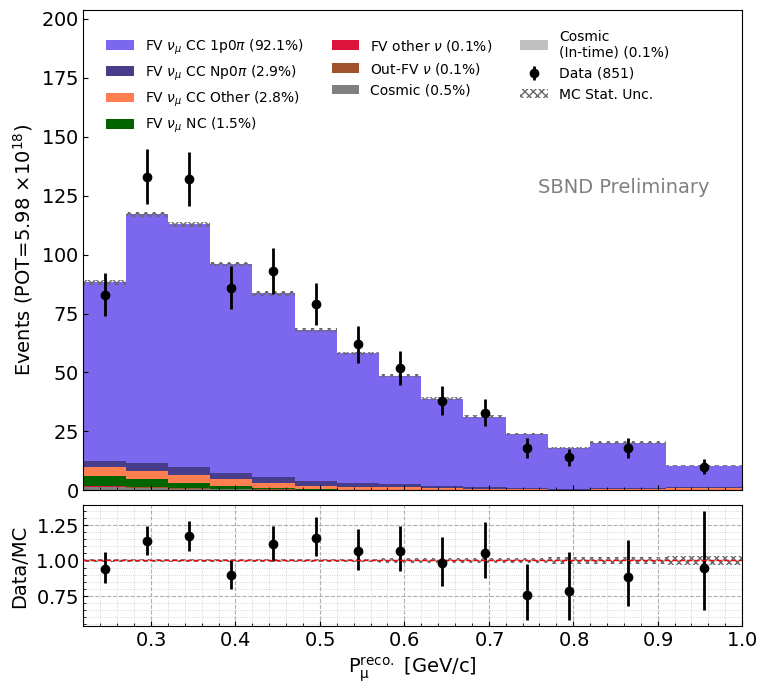

numu NC 1176


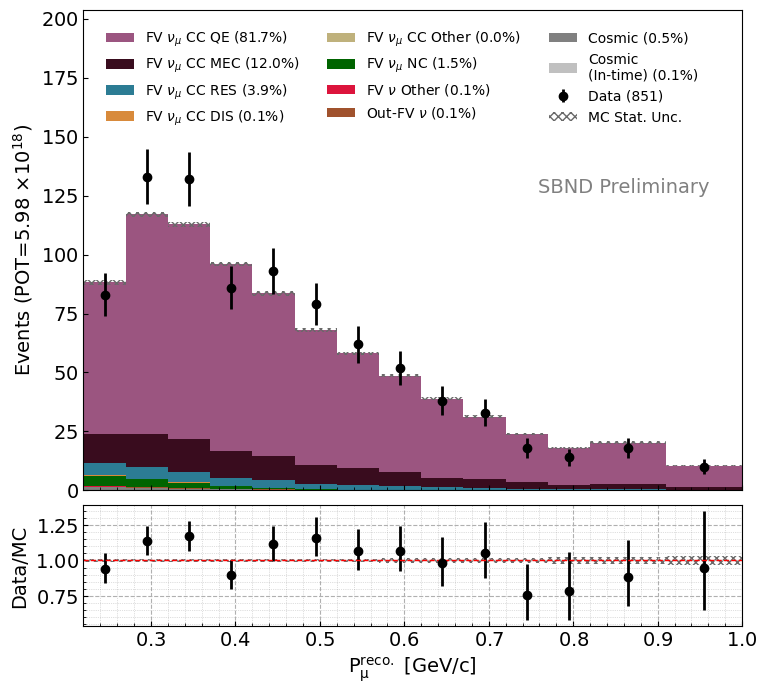

numu NC 1176


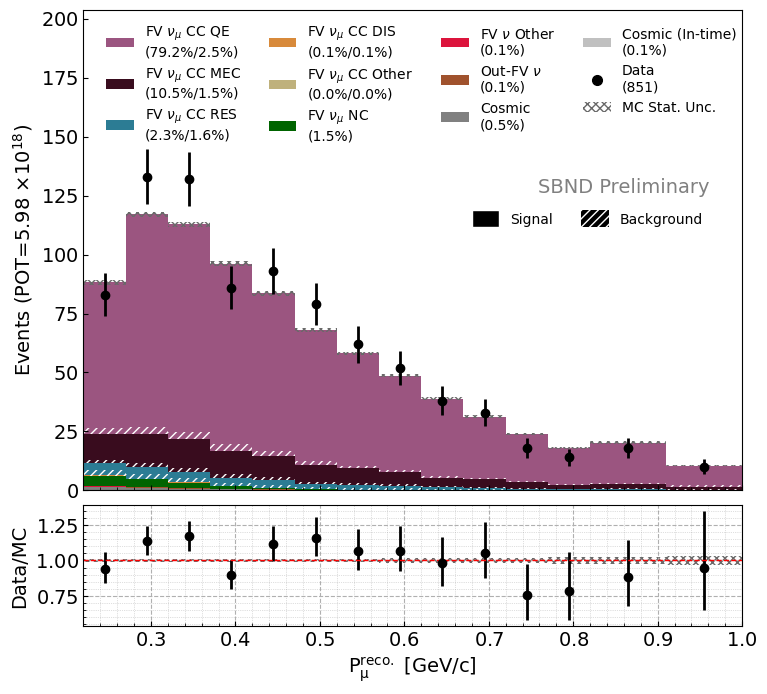

In [63]:
# muon momentum 
var_config = VariableConfig.muon_momentum()
evtdf = mc_evt_df
vardf = evtdf.mu.pfp.trk.rangeP.p_muon
vardf_data = data_evt_df.mu.pfp.trk.rangeP.p_muon
vardf_intime = intime_mu_df.pfp.trk.rangeP.p_muon
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)

# plot
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

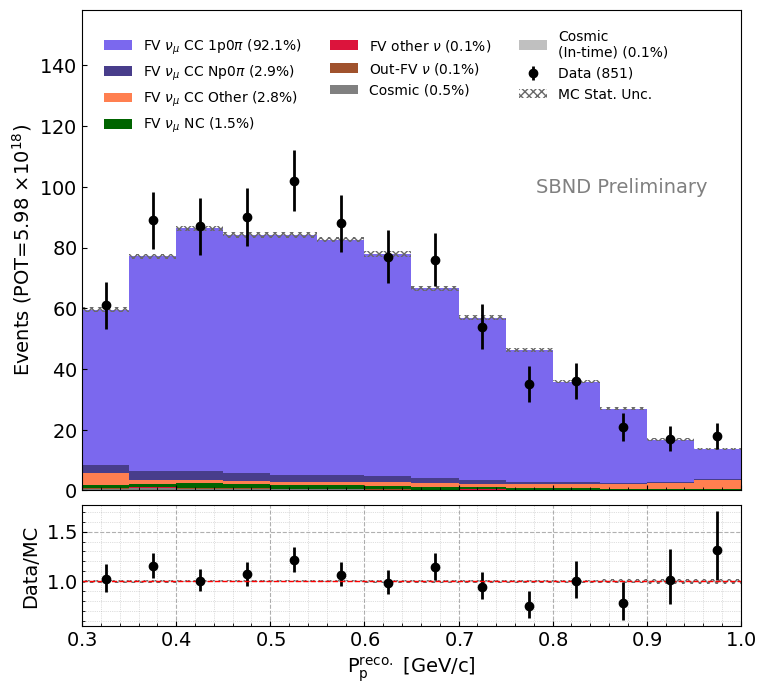

numu NC 1176


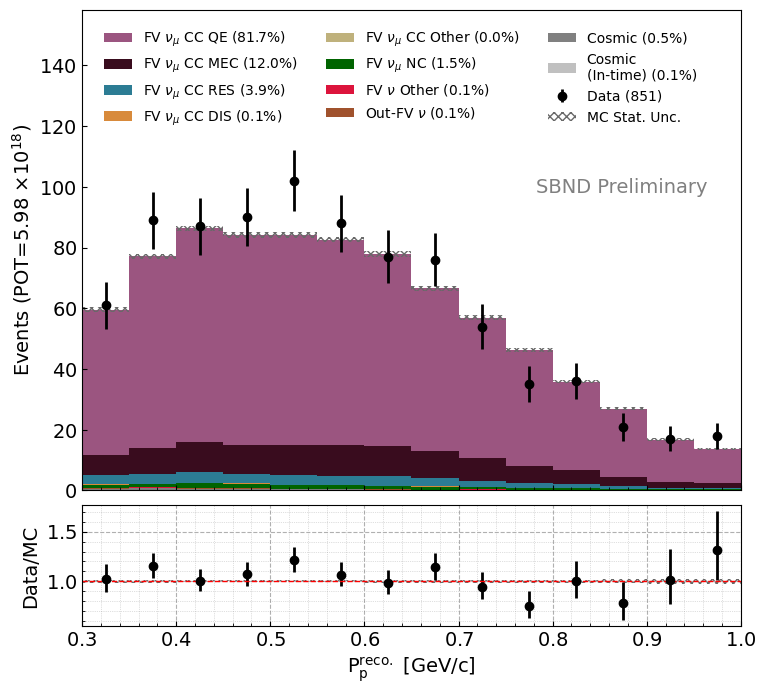

numu NC 1176


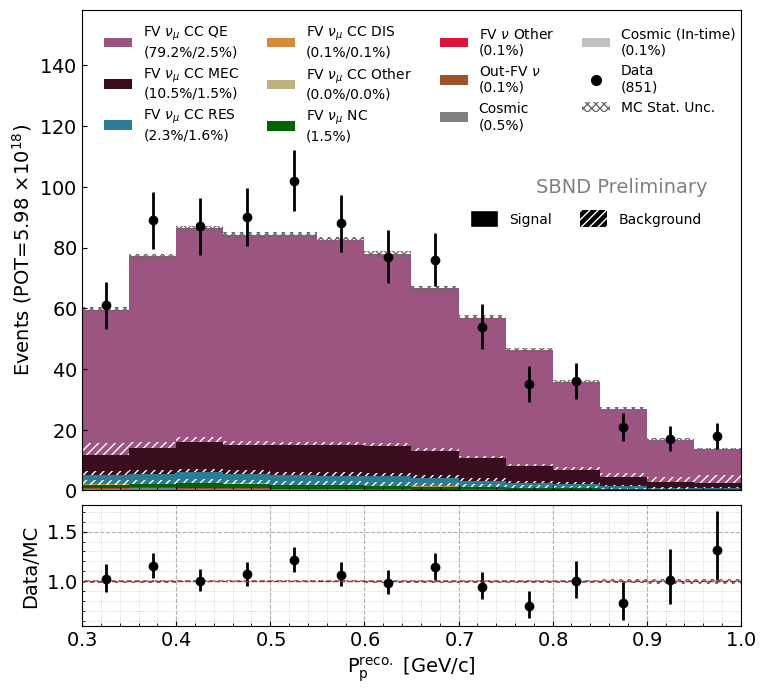

In [64]:
# proton momentum 
var_config = VariableConfig.proton_momentum()
evtdf = mc_evt_df
vardf = evtdf.p.pfp.trk.rangeP.p_proton
vardf_data = data_evt_df.p.pfp.trk.rangeP.p_proton
vardf_intime = intime_p_df.pfp.trk.rangeP.p_proton
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

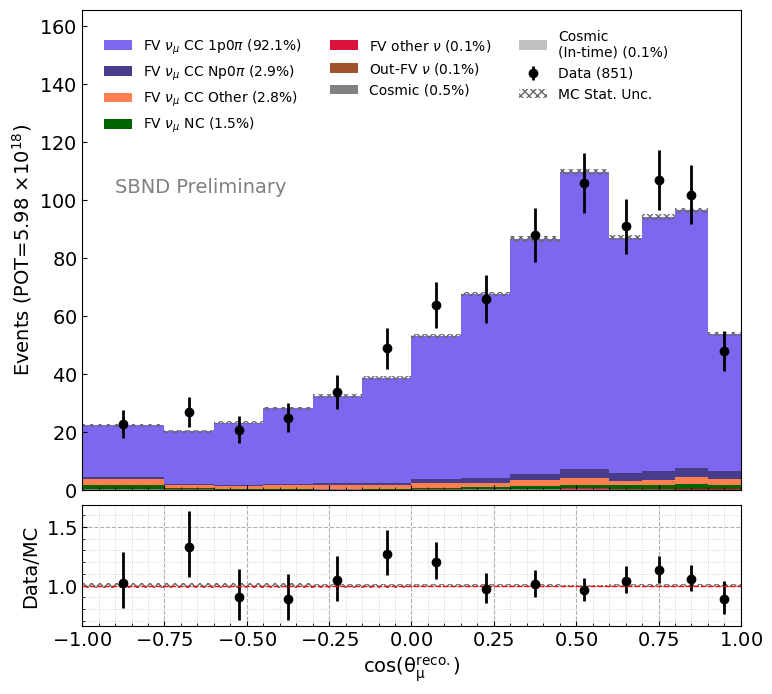

numu NC 1176


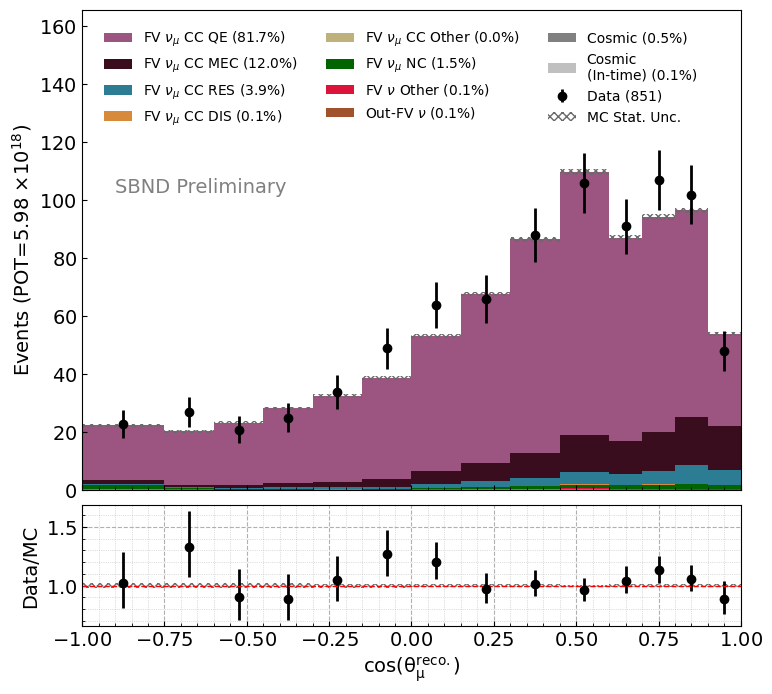

numu NC 1176


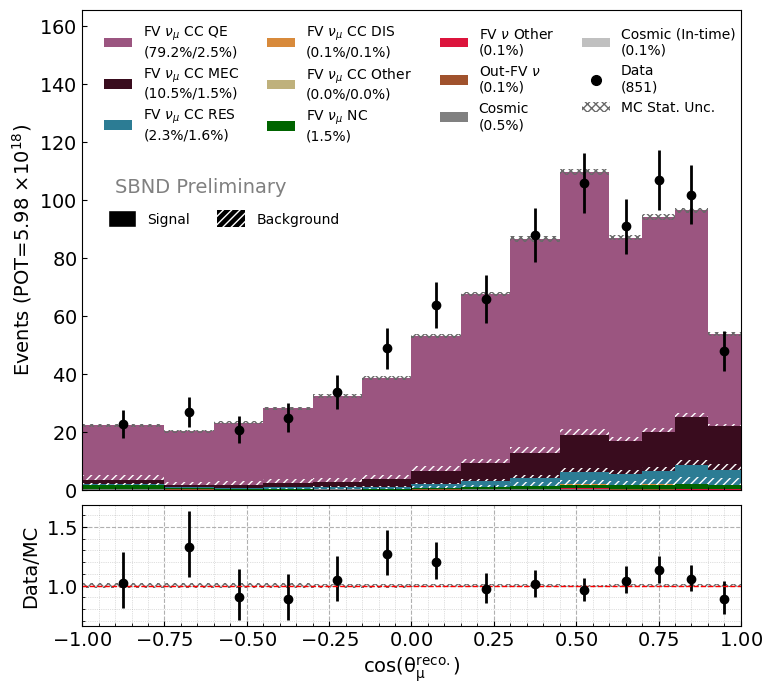

In [65]:
# Muon z-direction
var_config = VariableConfig.muon_direction()
evtdf = mc_evt_df
vardf = evtdf.mu.pfp.trk.dir.z
vardf_data = data_evt_df.mu.pfp.trk.dir.z
vardf_intime = intime_mu_df.pfp.trk.dir.z
bins = var_config.bins
vardf = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels, legendloc="left",
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

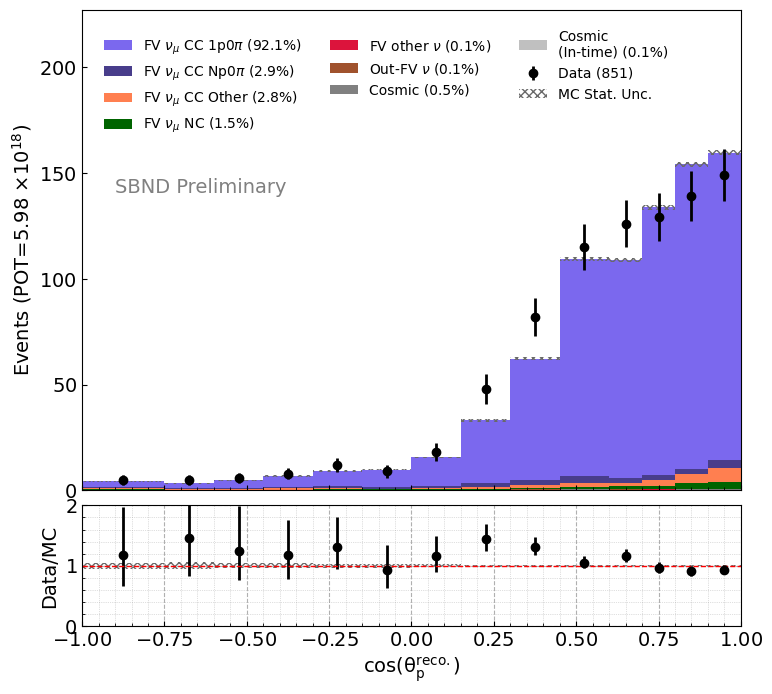

numu NC 1176


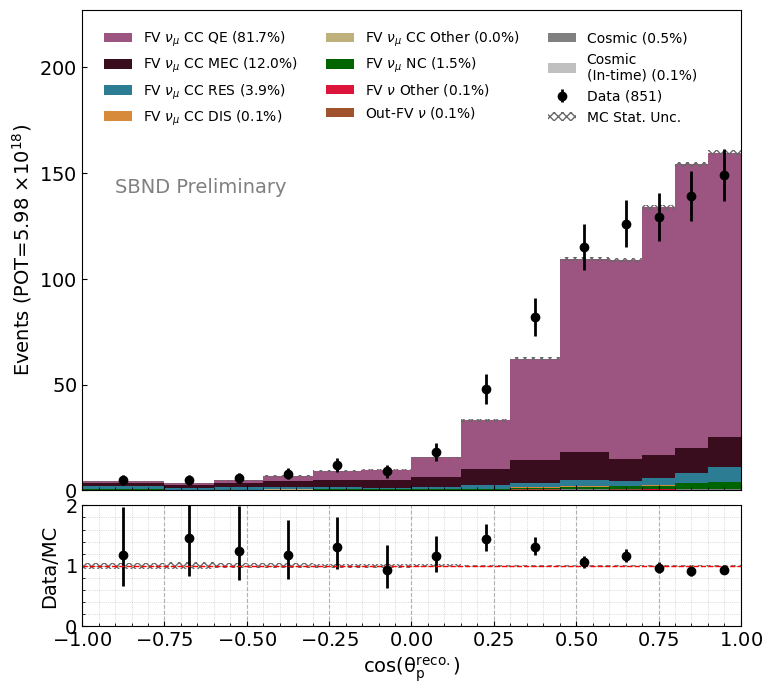

numu NC 1176


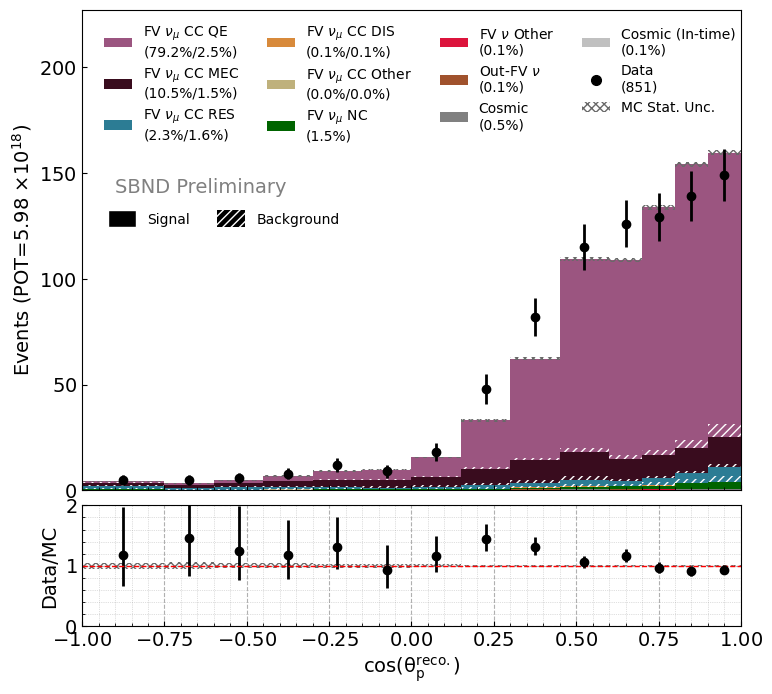

In [66]:
# proton z-direction
var_config = VariableConfig.proton_direction()
evtdf = mc_evt_df
vardf = evtdf.p.pfp.trk.dir.z
vardf_data = data_evt_df.p.pfp.trk.dir.z
vardf_intime = intime_p_df.pfp.trk.dir.z
bins = var_config.bins
vardf = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels, legendloc="left",
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

In [61]:
from pyanalib.pandas_helpers import pad_column_name
from pyanalib.variable_calculator import get_cc1p0pi_tki

# mc_mu_df = mc_mu_df.reset_index(level=[3])
# mc_p_df = mc_p_df.reset_index(level=[3])

# data_mu_df = data_mu_df.reset_index(level=[3])
# data_p_df = data_p_df.reset_index(level=[3])

# intime_mu_df = intime_mu_df.reset_index(level=[3])
# intime_p_df = intime_p_df.reset_index(level=[3])

# mudf = mc_mu_df#.reset_index(level=[3])
# pdf = mc_p_df#.reset_index(level=[3])
# P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
# P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
# mc_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

# mudf = data_mu_df#.reset_index(level=[3])
# pdf = data_p_df#.reset_index(level=[3])
# data_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

mudf = intime_mu_df#.reset_index(level=[3])
pdf = intime_p_df#.reset_index(level=[3])
P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
intime_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

In [42]:
# mc_ret_tki.keys()

In [43]:
mc_evt_df.del_Tp

__ntuple  entry  rec.slc..index
0         8153   0                 0.079856
          16612  0                 0.290498
          7499   2                 0.145114
          12722  0                 0.232072
          12108  0                 0.048523
                                     ...   
389       9035   2                 0.044909
          5474   1                 0.271165
          1153   0                 0.050383
          8787   4                 0.125861
          16107  0                 0.102727
Name: del_Tp, Length: 79841, dtype: float64

In [45]:
# mc_evt_df_mup["del_Tp_x"] = mc_ret_tki["del_Tp_x"]
# mc_evt_df_mup["del_Tp_y"] = mc_ret_tki["del_Tp_y"]
# mc_evt_df_mup["del_Tp"] = mc_ret_tki["del_Tp"]
# mc_evt_df_mup["del_p"] = mc_ret_tki["del_p"]
# mc_evt_df_mup["del_alpha"] = mc_ret_tki["del_alpha"]
# mc_evt_df_mup["del_phi"] = mc_ret_tki["del_phi"]

# data_evt_df_mup["del_Tp_x"] = data_ret_tki["del_Tp_x"]
# data_evt_df_mup["del_Tp_y"] = data_ret_tki["del_Tp_y"]
# data_evt_df_mup["del_Tp"] = data_ret_tki["del_Tp"]
# data_evt_df_mup["del_p"] = data_ret_tki["del_p"]
# data_evt_df_mup["del_alpha"] = data_ret_tki["del_alpha"]
# data_evt_df_mup["del_phi"] = data_ret_tki["del_phi"]

intime_evt_df_mup["del_Tp_x"] = intime_ret_tki["del_Tp_x"]
intime_evt_df_mup["del_Tp_y"] = intime_ret_tki["del_Tp_y"]
intime_evt_df_mup["del_Tp"] = intime_ret_tki["del_Tp"]
intime_evt_df_mup["del_p"] = intime_ret_tki["del_p"]
intime_evt_df_mup["del_alpha"] = intime_ret_tki["del_alpha"]
intime_evt_df_mup["del_phi"] = intime_ret_tki["del_phi"]

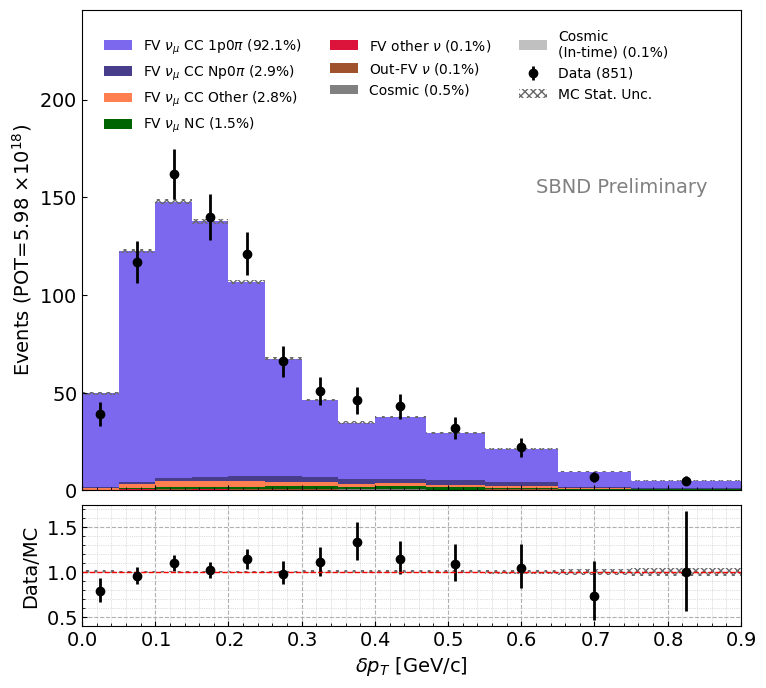

numu NC 1176


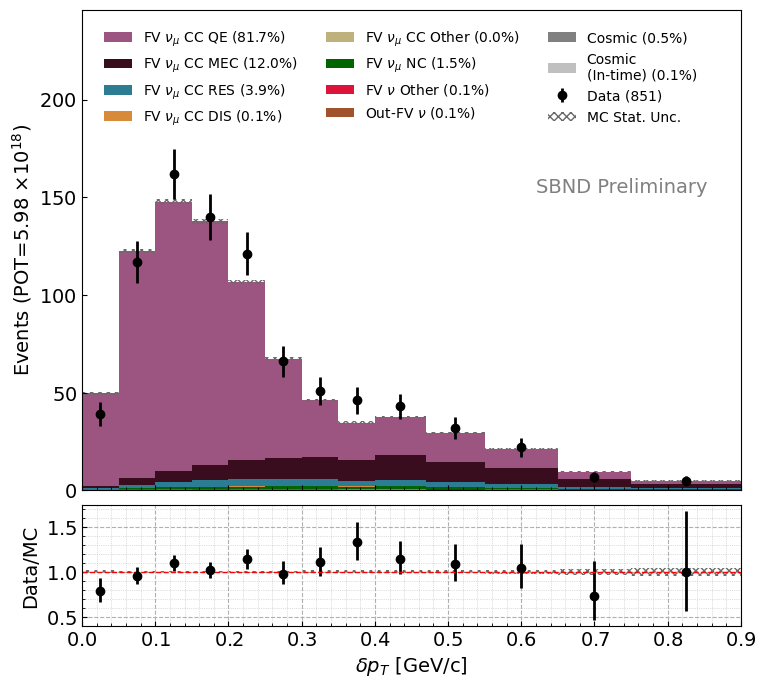

numu NC 1176


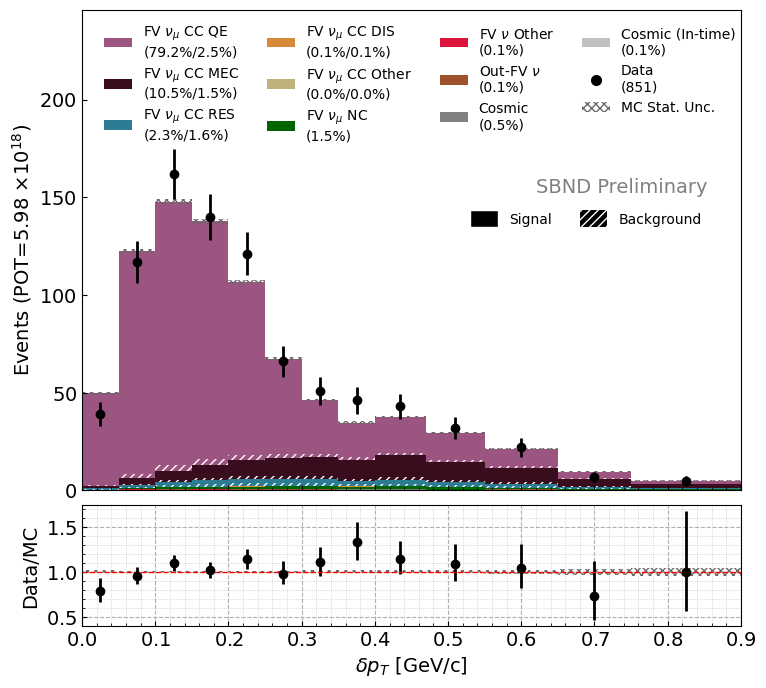

In [67]:
evtdf = mc_evt_df
tki_name = "del_Tp"
var_config = VariableConfig.tki_del_Tp()
vardf = evtdf[tki_name]
vardf_data = data_evt_df[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_T$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

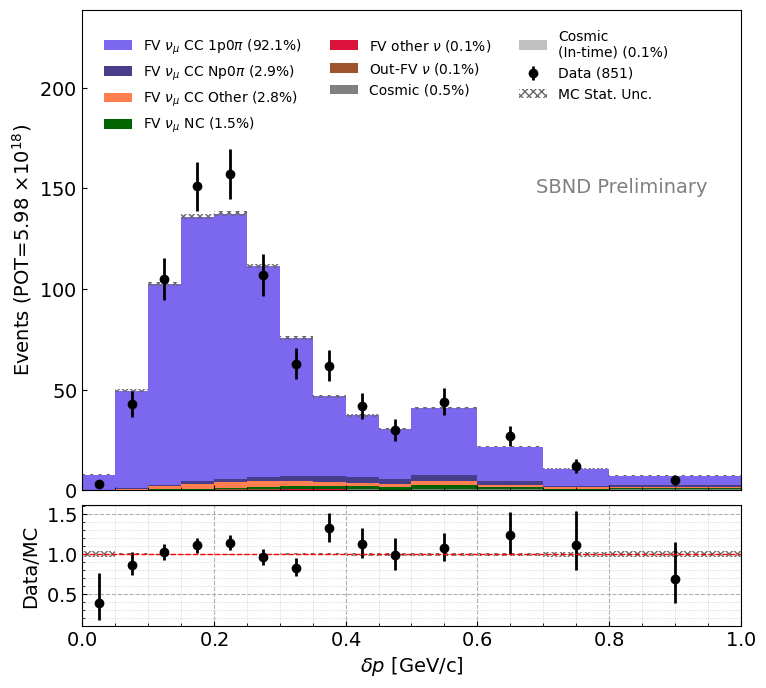

numu NC 1176


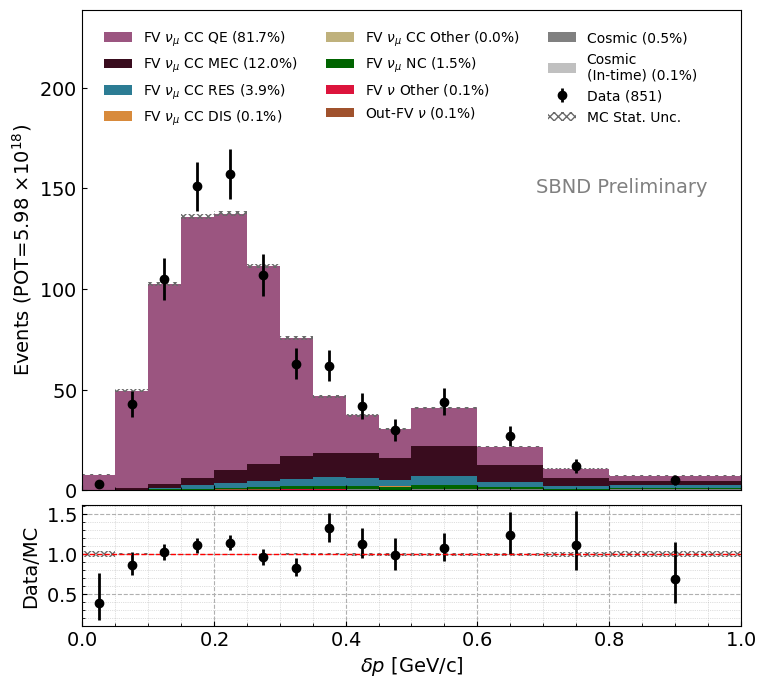

numu NC 1176


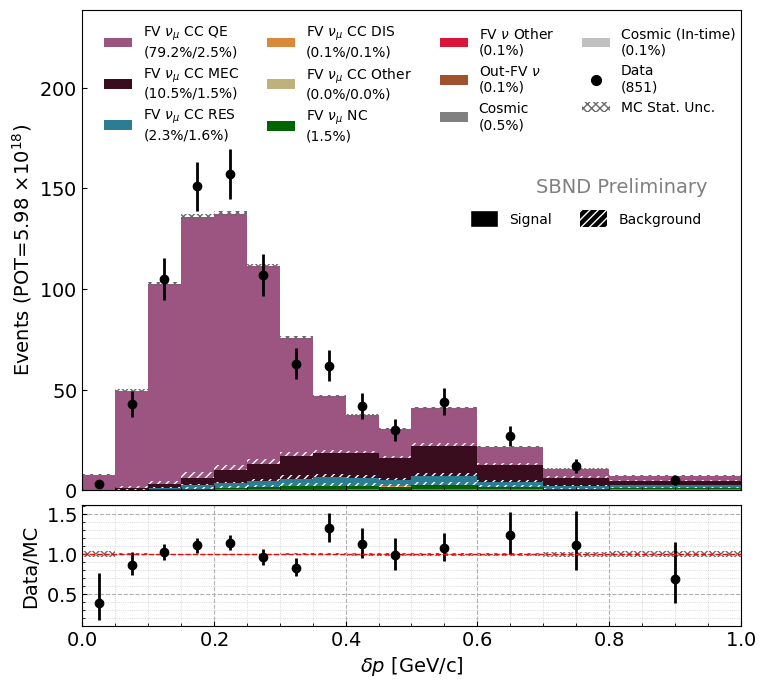

In [68]:
# Muon z-direction
evtdf = mc_evt_df
tki_name = "del_p"
var_config = VariableConfig.tki_del_p()
vardf = evtdf[tki_name]
vardf_data = data_evt_df[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/tki-del_p_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-del_p_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-del_p_{}.png".format(plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

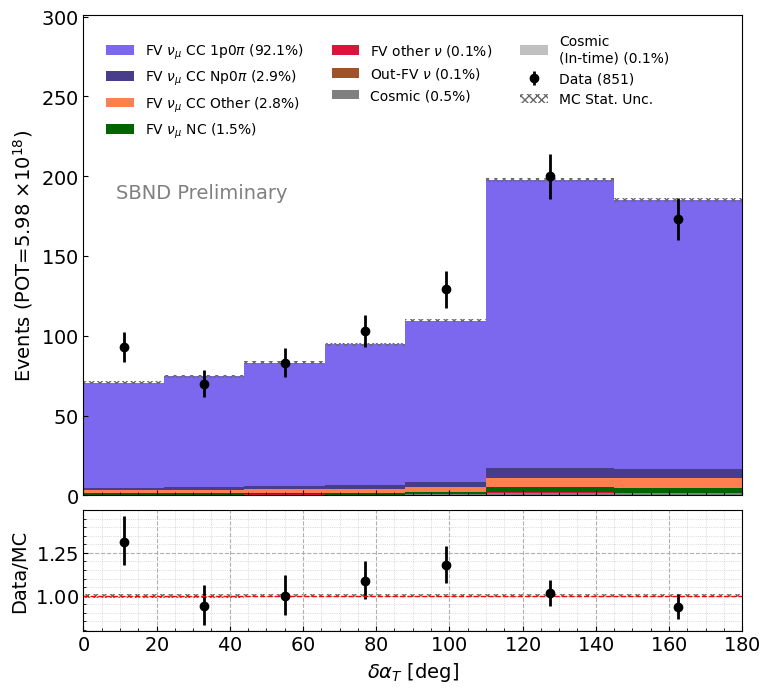

numu NC 1176


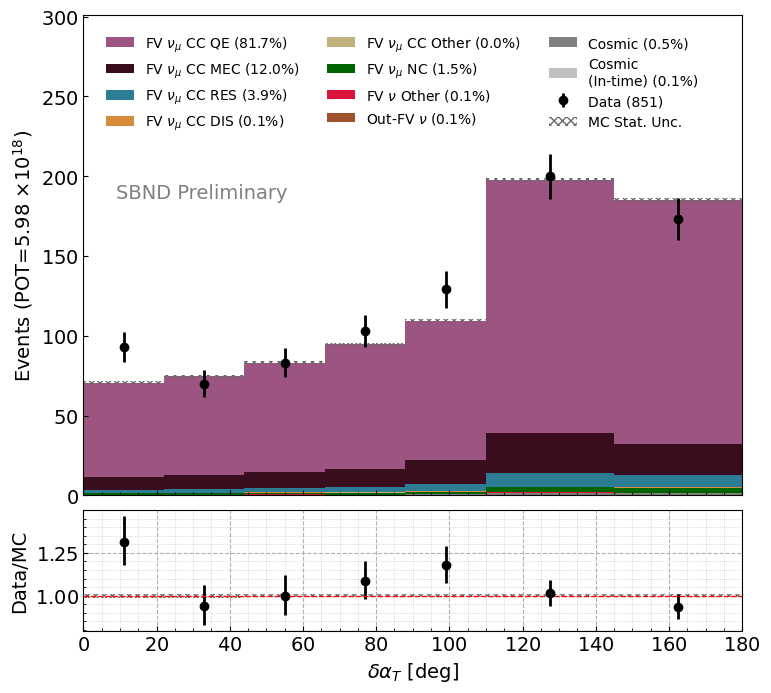

numu NC 1176


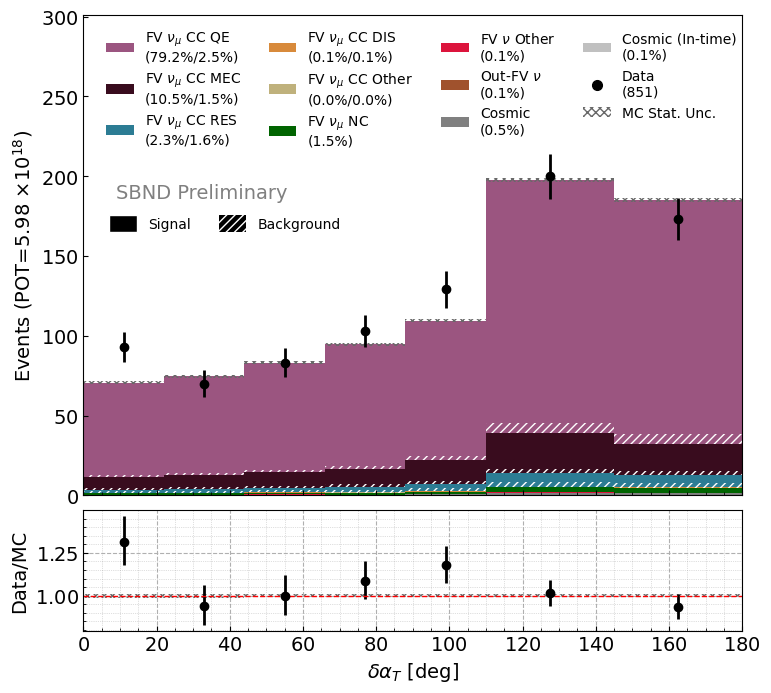

In [69]:
# Muon z-direction
evtdf = mc_evt_df
tki_name = "del_alpha"
var_config = VariableConfig.tki_del_alpha()
vardf = evtdf[tki_name]
vardf_data = data_evt_df[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta \alpha_T$ [deg]",
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels, legendloc="left",
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

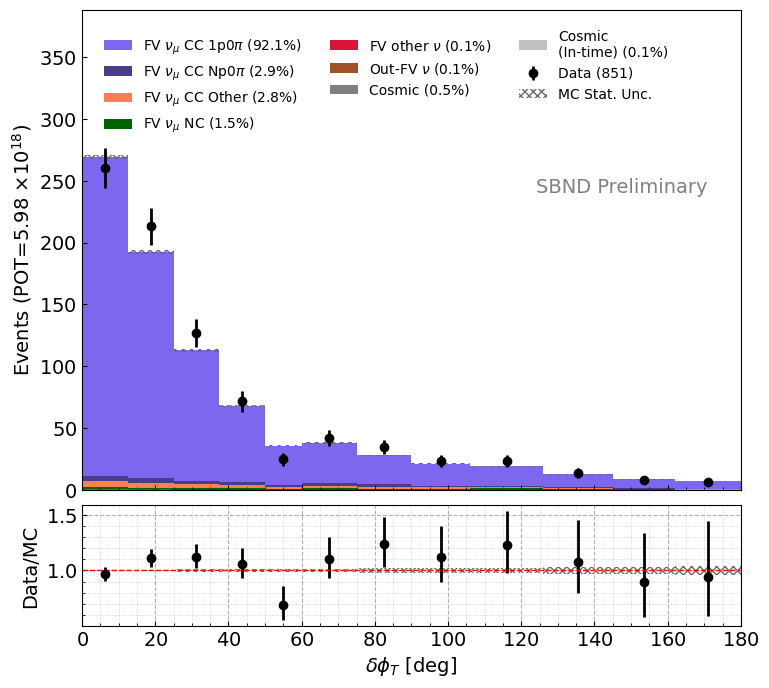

numu NC 1176


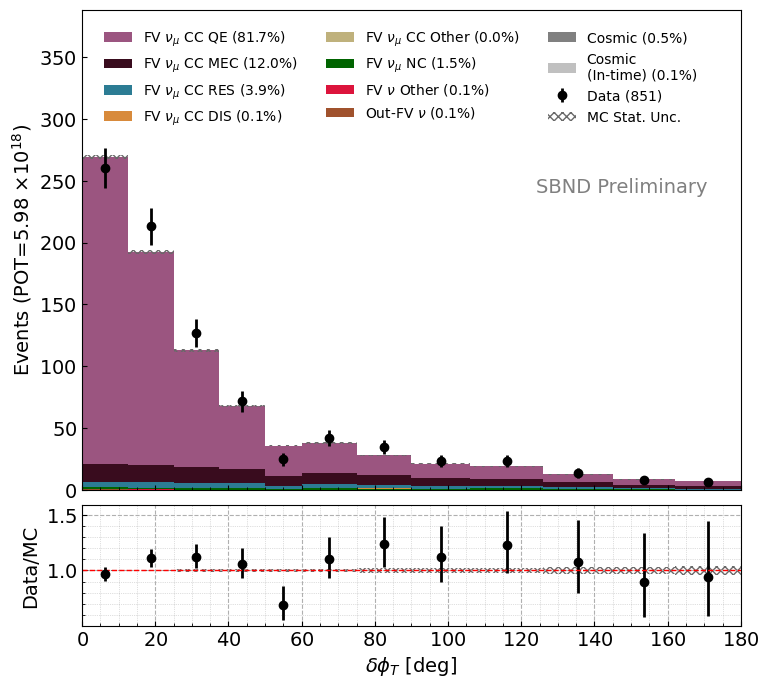

numu NC 1176


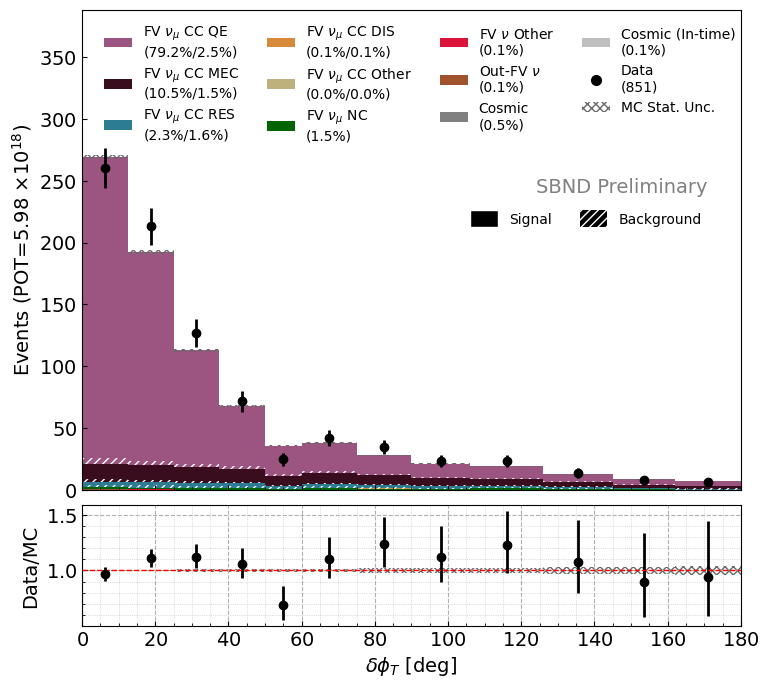

In [70]:
# Muon z-direction
evtdf = mc_evt_df
tki_name = "del_phi"
var_config = VariableConfig.tki_del_phi()
vardf = evtdf[tki_name]
vardf_data = data_evt_df[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta \phi_T$ [deg]",
               "Events (POT={})".format(pot_str), ""]

approval = "preliminary"

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          approval=approval,
                          save_fig=save_fig, save_name=save_name)

# Look at different TPC regions

In [ ]:
data_evt_df_mup = data_evt_df_mup[InFV(data_evt_df_mup.slc.vertex)]

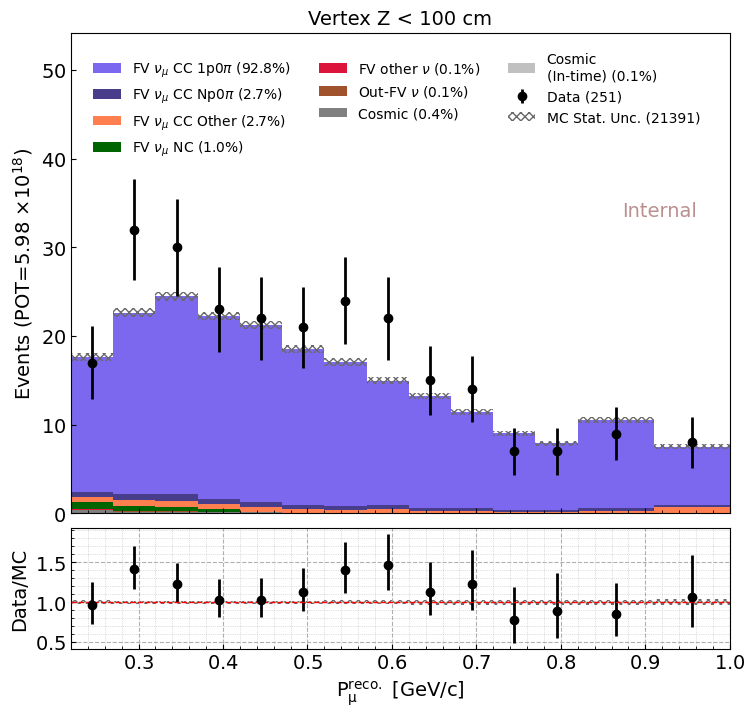

In [ ]:
# muon momentum 
var_config = VariableConfig.muon_momentum()
mc_mask = (mc_evt_df_mup.slc.vertex.z > 20) & (mc_evt_df_mup.slc.vertex.z < 100)
evtdf = mc_evt_df_mup[mc_mask]
vardf = mc_mu_df[mc_mask].pfp.trk.rangeP.p_muon
data_mask = (data_evt_df_mup.slc.vertex.z > 20) & (data_evt_df_mup.slc.vertex.z < 100)
vardf_data = data_mu_df[data_mask].pfp.trk.rangeP.p_muon
intime_mask = (intime_evt_df_mup.slc.vertex.z > 20) & (intime_evt_df_mup.slc.vertex.z < 100)
vardf_intime = intime_mu_df[intime_mask].pfp.trk.rangeP.p_muon
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)

# plot
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), "Vertex Z < 100 cm"]

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}_z_l_0_100.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

In [ ]:
# z_bins = [10, 100, 200, 300, 450]

# for i in range(len(z_bins)-1):
#     z_min = z_bins[i]
#     z_max = z_bins[i+1]
#     var_config = VariableConfig.muon_momentum()
#     mc_mask = (mc_evt_df_mup.slc.vertex.z > z_min) & (mc_evt_df_mup.slc.vertex.z < z_max)
#     evtdf = mc_evt_df_mup[mc_mask]
#     vardf = mc_mu_df[mc_mask].mu.pfp.trk.rangeP.p_muon
#     data_mask = (data_evt_df_mup.slc.vertex.z > z_min) & (data_evt_df_mup.slc.vertex.z < z_max)
#     vardf_data = data_mu_df[data_mask].pfp.trk.rangeP.p_muon
#     intime_mask = (intime_evt_df_mup.slc.vertex.z > z_min) & (intime_evt_df_mup.slc.vertex.z < z_max)
#     vardf_intime = intime_mu_df[intime_mask].pfp.trk.rangeP.p_muon
#     bins = var_config.bins
#     vardf = np.clip(vardf, bins[0], bins[-1] - eps)
#     vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
#     vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)

#     # plot
#     plot_labels = [var_config.var_labels[1], 
#                 "Events (POT={})".format(pot_str), "{} < Z < {} cm".format(z_min, z_max)]

#     plot_type = "topology"
#     save_name = save_fig_dir + "/{}_{}_z_l_0_100.png".format(var_config.var_save_name, plot_type)
#     ret_hist_topo = hist_plot(plot_type,
#                             evtdf, vardf, 
#                             vardf_data, vardf_intime,
#                             bins, 
#                             plot_labels,
#                             save_fig=save_fig, save_name=save_name)

In [ ]:
# var_config = VariableConfig.muon_direction()
# z_bins = [-200, -100, 0, 100, 200]

# for i in range(len(z_bins)-1):
#     z_min = z_bins[i]
#     z_max = z_bins[i+1]
#     mc_mask = (mc_evt_df_mup.slc.vertex.y > z_min) & (mc_evt_df_mup.slc.vertex.y < z_max)
#     evtdf = mc_evt_df_mup[mc_mask]
#     vardf = mc_mu_df[mc_mask].mu.pfp.trk.dir.z
#     data_mask = (data_evt_df_mup.slc.vertex.y > z_min) & (data_evt_df_mup.slc.vertex.y < z_max)
#     vardf_data = data_mu_df[data_mask].pfp.trk.dir.z
#     intime_mask = (intime_evt_df_mup.slc.vertex.y > z_min) & (intime_evt_df_mup.slc.vertex.y < z_max)
#     vardf_intime = intime_mu_df[intime_mask].pfp.trk.dir.z
#     bins = var_config.bins
#     vardf = np.clip(vardf, bins[0], bins[-1] - eps)
#     vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
#     vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)

#     # plot
#     plot_labels = [var_config.var_labels[1], 
#                 "Events (POT={})".format(pot_str), "{} < Vertex Y [cm] < {}".format(z_min, z_max)]

#     plot_type = "topology"
#     save_name = save_fig_dir + "/{}_{}_z_l_0_100.png".format(var_config.var_save_name, plot_type)
#     ret_hist_topo = hist_plot(plot_type,
#                             evtdf, vardf, 
#                             vardf_data, vardf_intime,
#                             bins, 
#                             plot_labels,
#                             save_fig=save_fig, save_name=save_name)

In [ ]:
mc_mu_df

pfp                                   \
                              tindex      trk                           
                                     producer       start               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
21       6597  1                   0        0   86.038452 -111.914841   
321      4632  0                   0        0  -82.512436  -42.191860   
109      17098 1                   0        0  133.752167  -86.354141   
387      2116  0                   0        0  -12.752584  -45.017941   
235      15079 0                   0        0   98.638191  -20.467031   
..                               ...      ...         ...         ...   
229      15032 0                   0        0 -148.343445  166.270126   
268      5269  1                   0        0   34.689919  -11.394110   
7        4686  0                   0        0  121.994858  -60.117115   
273      1348  2                   0        0  108.214157 -155.059250   
252      3577  0                   0        0  -50.021866   84.464668   

                                                                               \
                                                                                
                                                  end                           
                                        z           x           y           z   
                                                                                
                                                                                
                                                                                
__ntuple entry rec.slc..index                                                   
21       6597  1                32.090034 -111.908073   20.330860  346.911407   
321      4632  0               109.549042  162.827118  -26.112965  419.777496   
109      17098 1               109.937492  -72.902351  -22.653893  439.687500   
387      2116  0                16.410772  -78.582489   -3.665319  405.133881   
235      15079 0                26.812532  -82.519753   42.731979  372.872162   
..                                    ...         ...         ...         ...   
229      15032 0               170.693726 -149.552856  146.856903  212.951340   
268      5269  1               137.174118   81.078468    6.589832  134.492310   
7        4686  0                93.651314   84.629295  -90.014420  107.089981   
273      1348  2               103.181709  145.027847 -122.175240  109.751961   
252      3577  0               433.464661  -40.625954   37.737518  448.388947   

                                                   ...                         \
                                                   ...                          
                                    dir            ... is_contained         P   
                                      x         y  ...                 p_muon   
                                                   ...                          
                                                   ...                          
                                                   ...                          
__ntuple entry rec.slc..index                      ...                          
21       6597  1              -0.497877  0.332626  ...         True  0.999872   
321      4632  0               0.617139  0.040446  ...         True  0.999786   
109      17098 1              -0.519934  0.160267  ...         True  0.999602   
387      2116  0              -0.165629  0.104044  ...         True  0.999585   
235      15079 0              -0.455816  0.159016  ...         True  0.999543   
..                                  ...       ...  .

## Data vs. MC of other variables

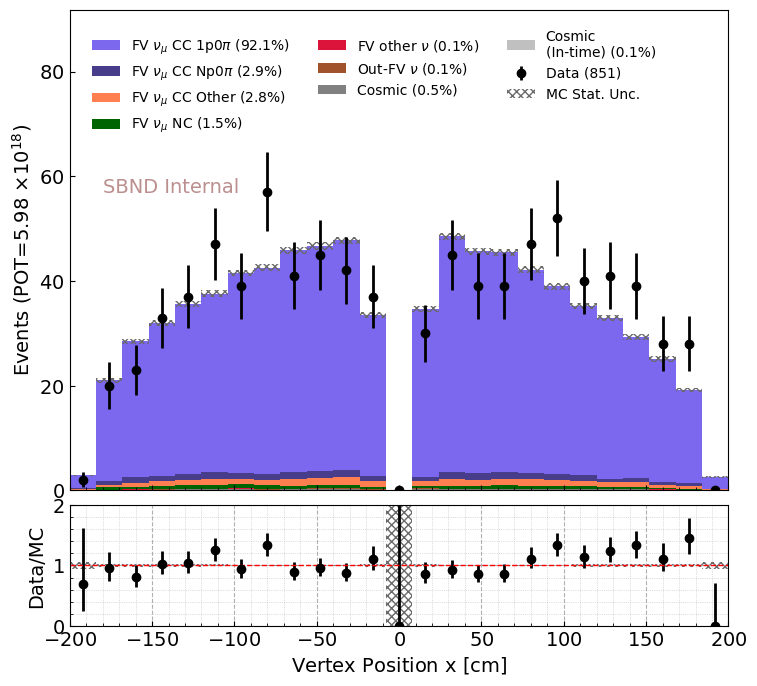

numu NC 1176


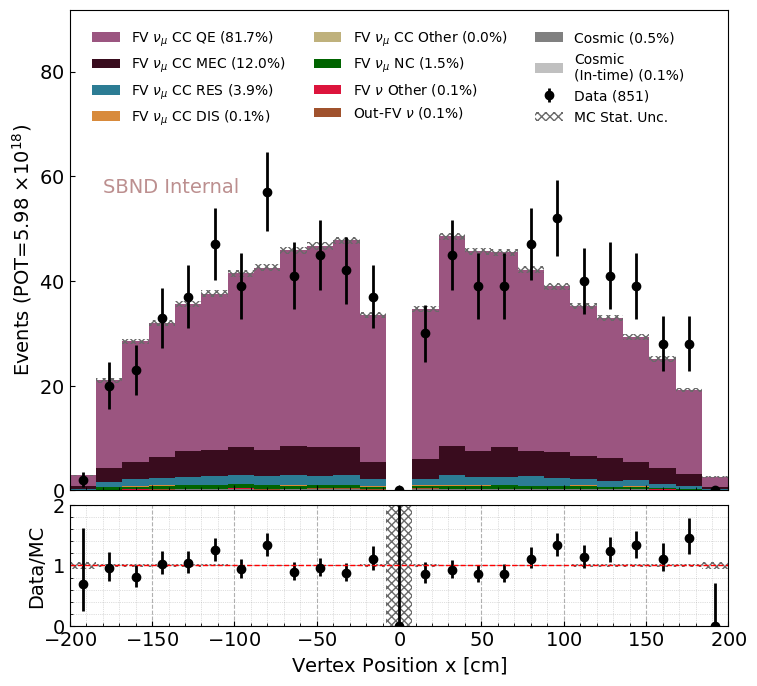

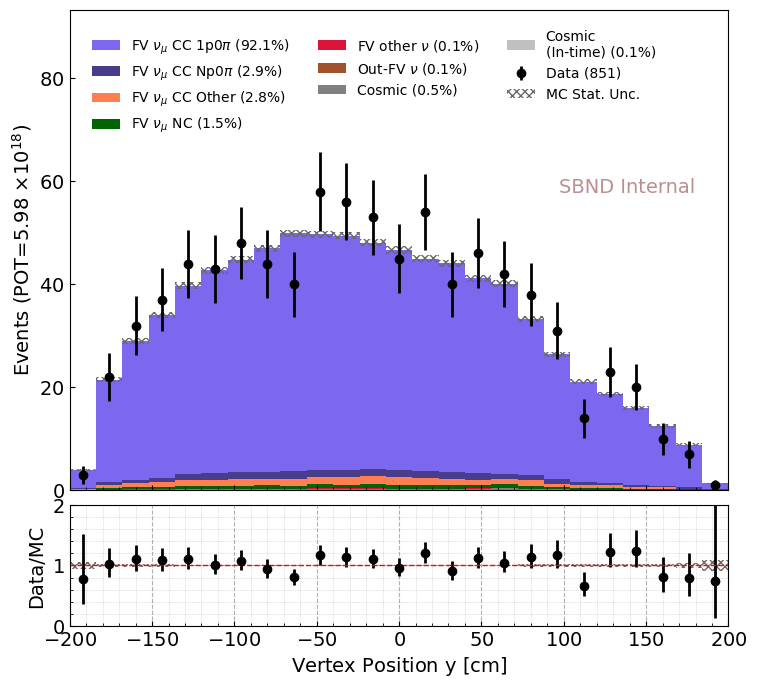

numu NC 1176


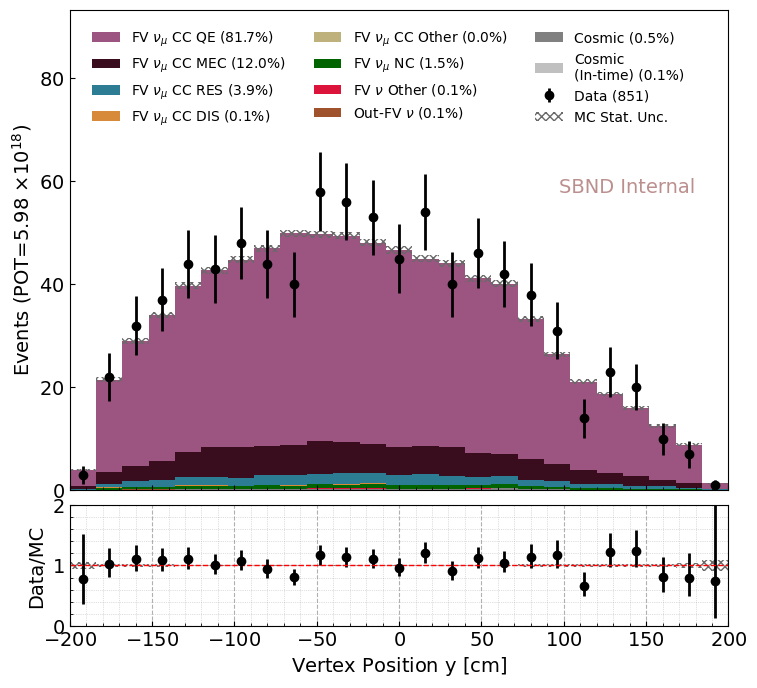

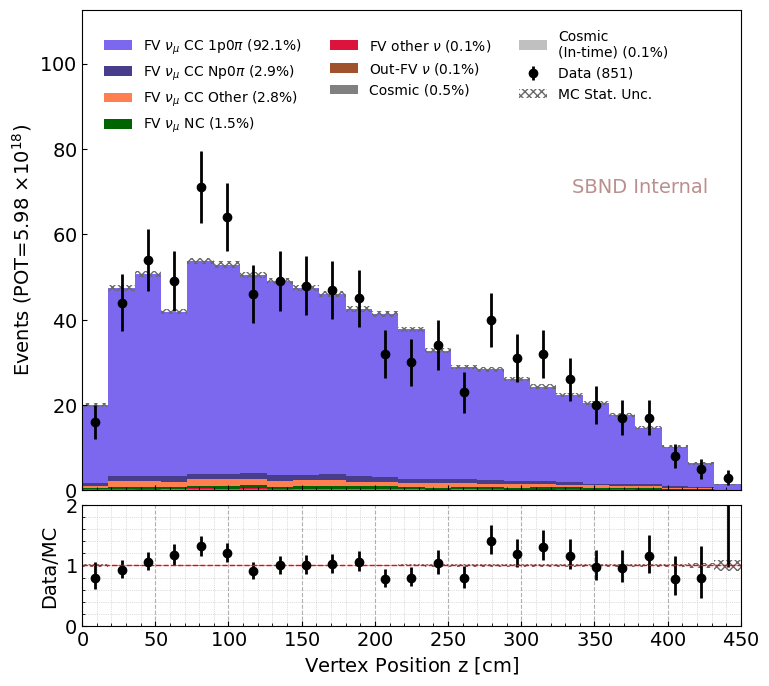

numu NC 1176


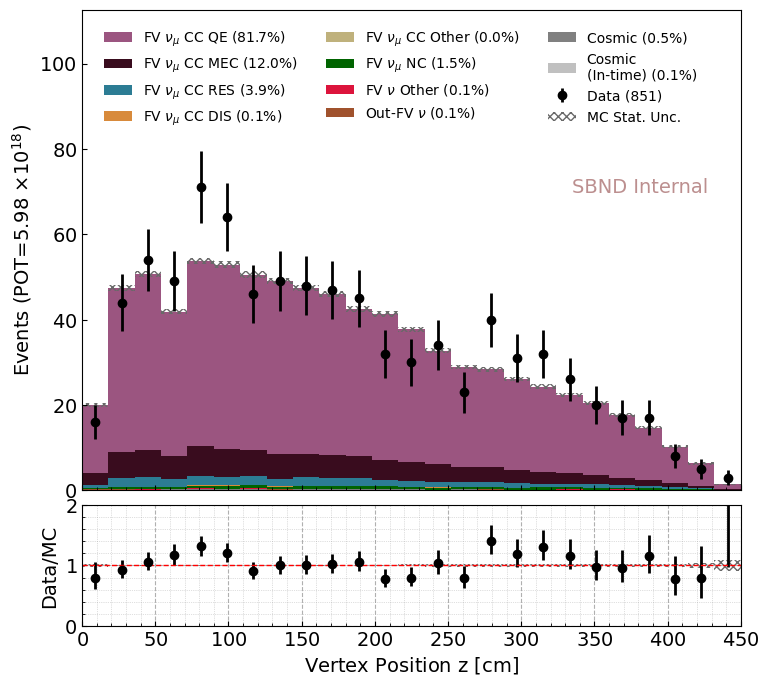

In [71]:
# slice vertex position
evtdf = mc_evt_df
vardf = evtdf.slc.vertex.x
vardf_data = data_evt_df.slc.vertex.x
vardf_intime = intime_evt_df_mup.slc.vertex.x
bins = np.linspace(-200,200,26)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"Vertex Position $\mathrm{x}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/slice_vertex_x_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/slice_vertex_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df
vardf = evtdf.slc.vertex.y
vardf_data = data_evt_df.slc.vertex.y
vardf_intime = intime_evt_df_mup.slc.vertex.y
bins = np.linspace(-200,200,26)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"Vertex Position $\mathrm{y}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/slice_vertex_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/slice_vertex_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df
vardf = evtdf.slc.vertex.z
vardf_data = data_evt_df.slc.vertex.z
vardf_intime = intime_evt_df_mup.slc.vertex.z
bins = np.linspace(0,450,26)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"Vertex Position $\mathrm{z}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/slice_vertex_z_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/slice_vertex_z_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

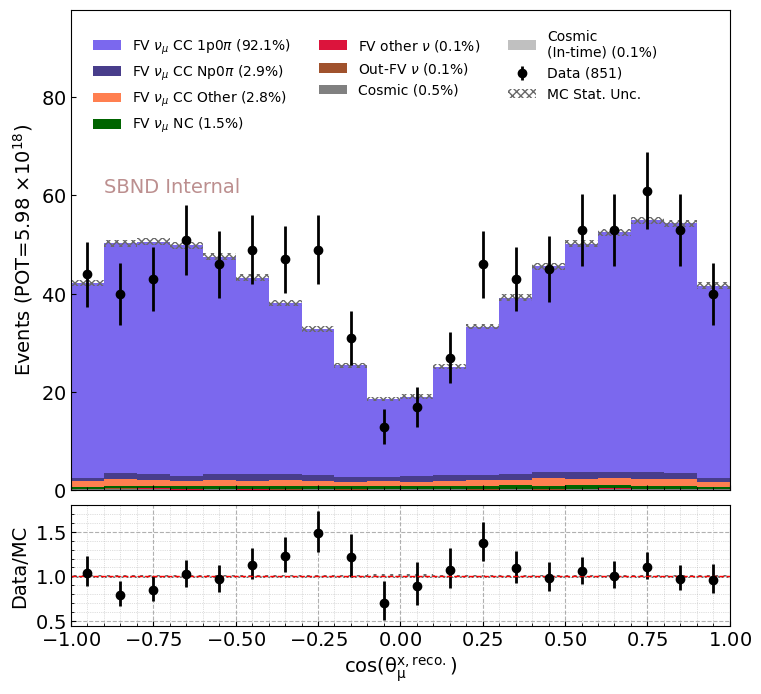

numu NC 1176


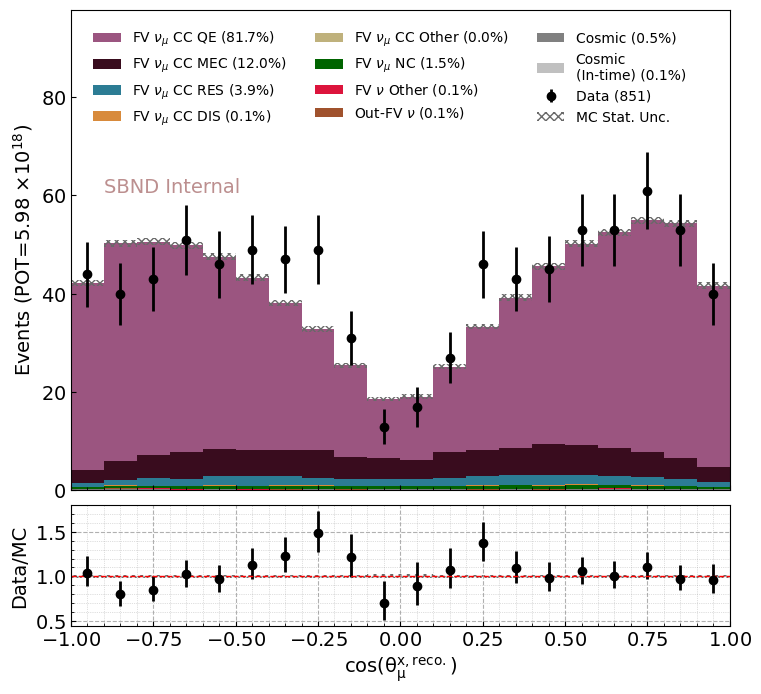

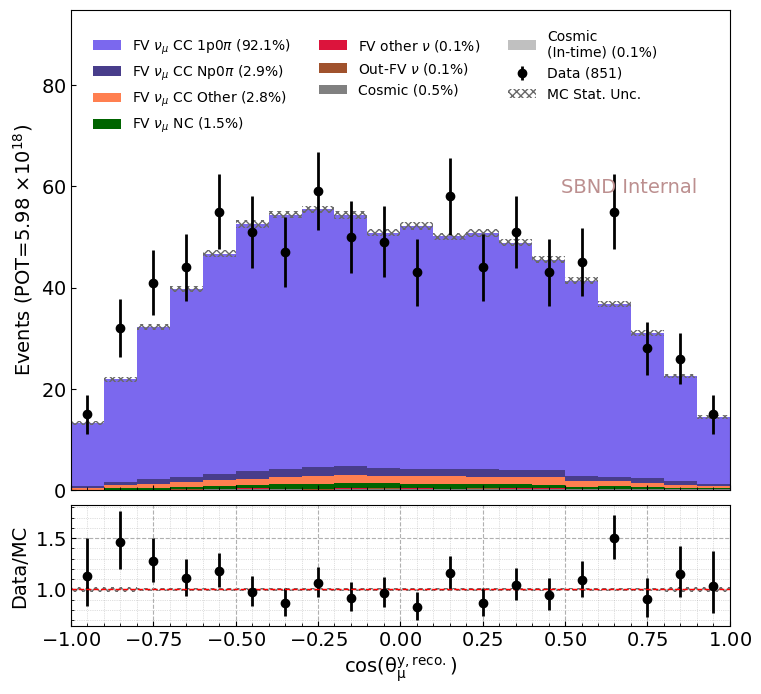

numu NC 1176


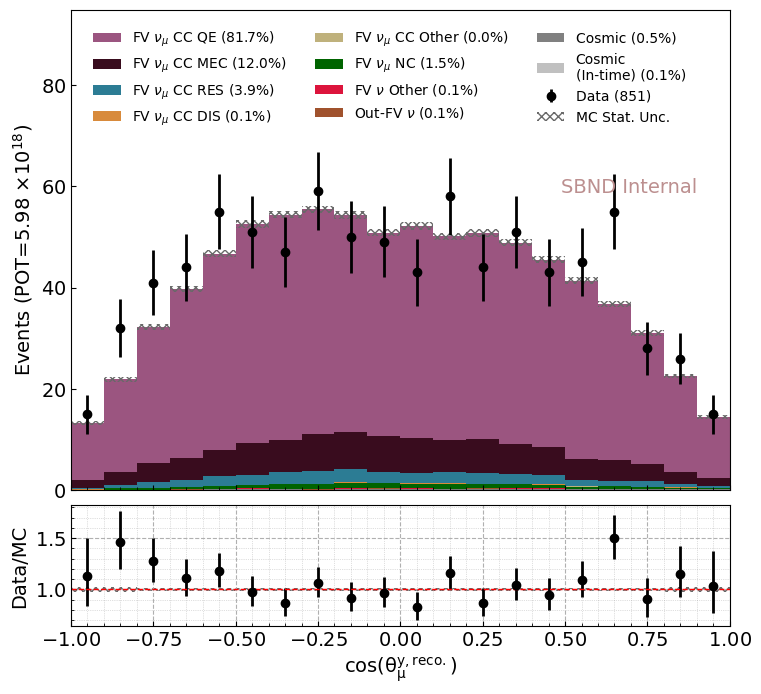

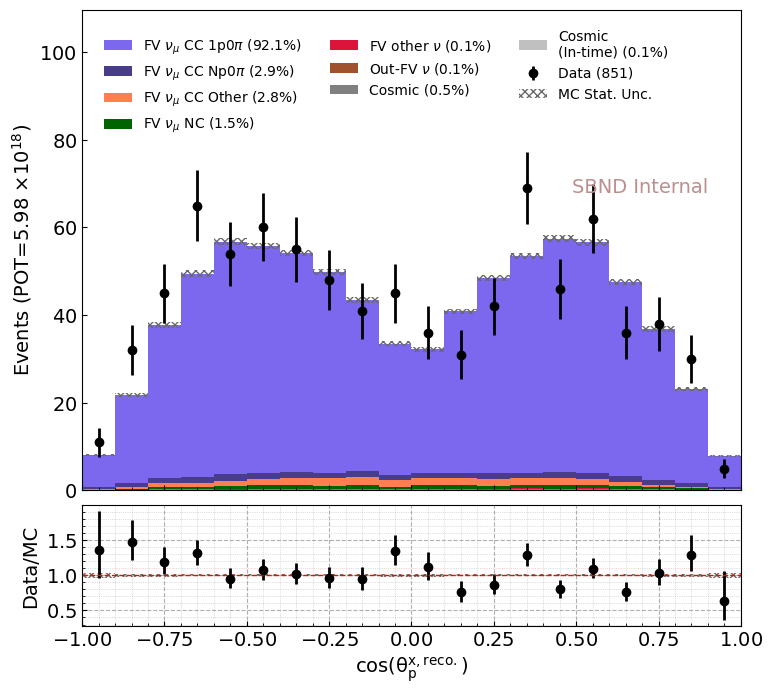

numu NC 1176


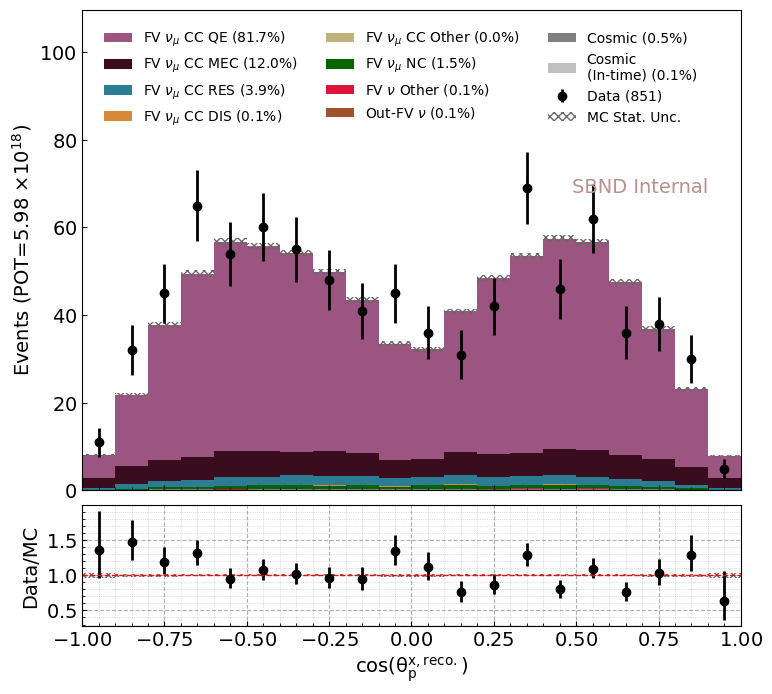

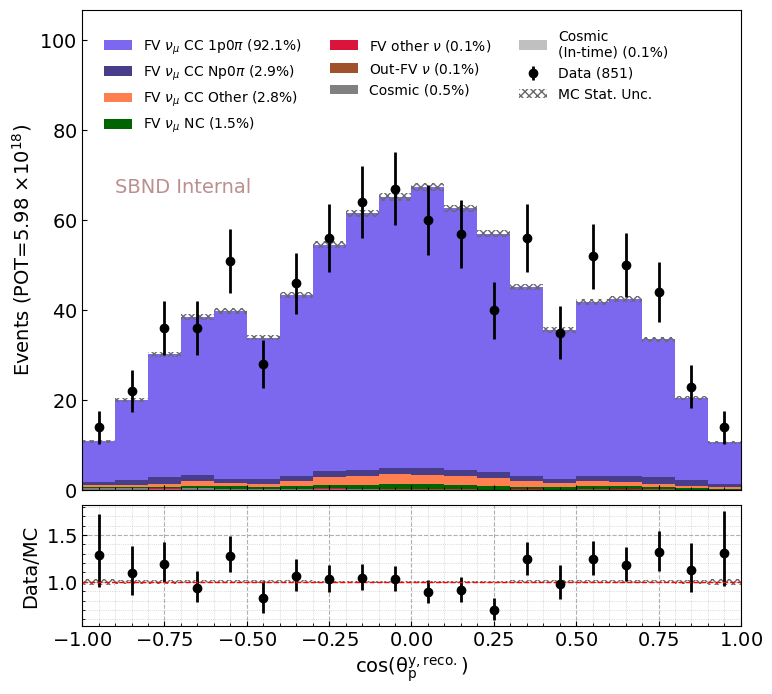

numu NC 1176


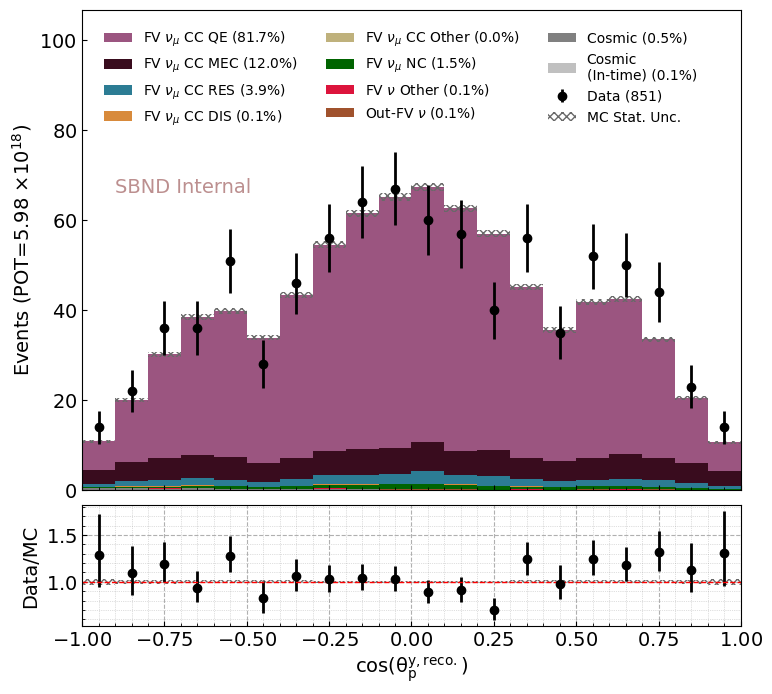

In [72]:
# mu & p directions

evtdf = mc_evt_df
vardf = evtdf.mu.pfp.trk.dir.x
vardf_data = data_evt_df.mu.pfp.trk.dir.x
vardf_intime = intime_mu_df.pfp.trk.dir.x
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu}^{x, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/mu_dir_x-{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/mu_dir_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df
vardf = evtdf.mu.pfp.trk.dir.y
vardf_data = data_evt_df.mu.pfp.trk.dir.y
vardf_intime = intime_mu_df.pfp.trk.dir.y
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu}^{y, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/mu_dir_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/mu_dir_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

# proton

evtdf = mc_evt_df
vardf = evtdf.p.pfp.trk.dir.x
vardf_data = data_evt_df.p.pfp.trk.dir.x
vardf_intime = intime_p_df.pfp.trk.dir.x
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_p^{x, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/p_dir_x_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/p_dir_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df
vardf = evtdf.p.pfp.trk.dir.y
vardf_data = data_evt_df.p.pfp.trk.dir.y
vardf_intime = intime_p_df.pfp.trk.dir.y
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_p^{y, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/p_dir_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/p_dir_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

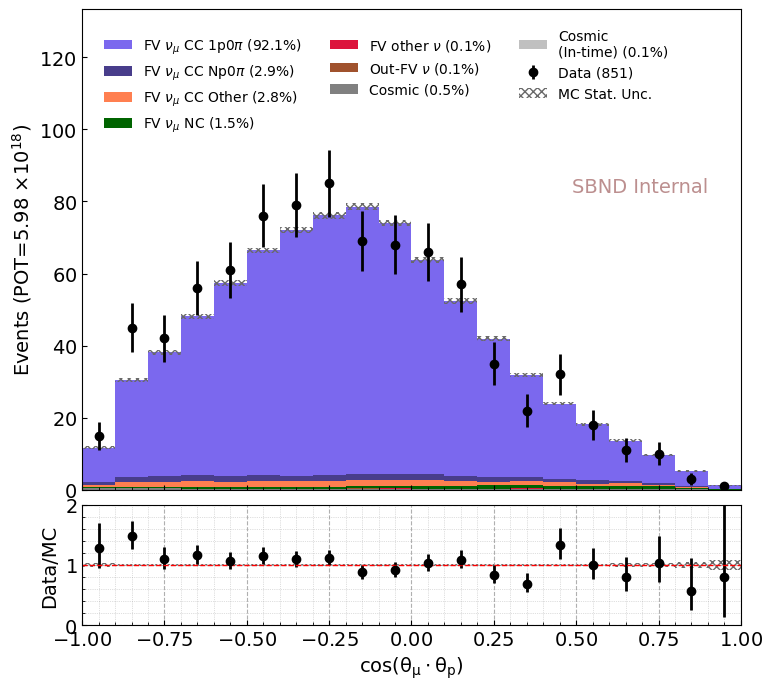

numu NC 1176


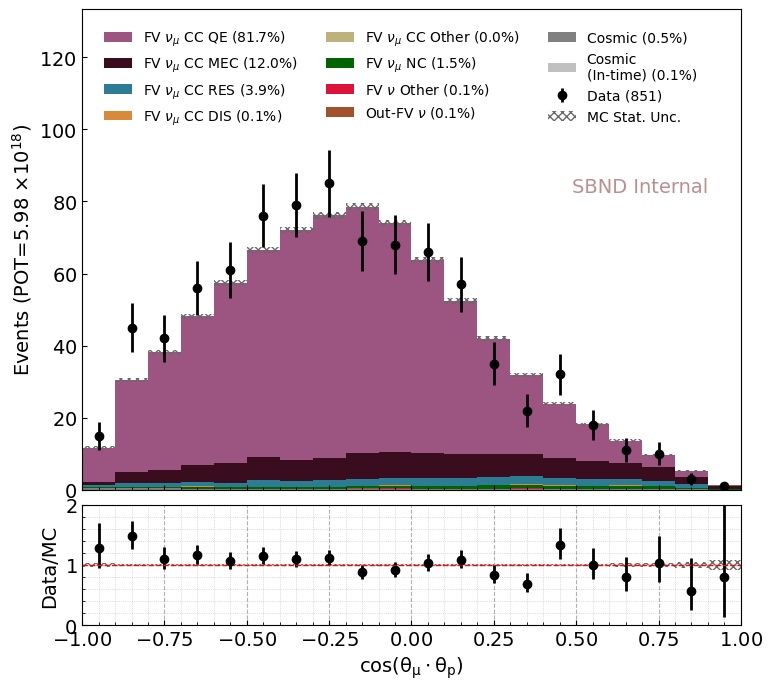

In [73]:
# opening angle
evtdf = mc_evt_df
mcdf = evtdf.mu #.reset_index(level=[3])
pudf = evtdf.p #.reset_index(level=[3])
vardf = mcdf.pfp.trk.dir.x * pudf.pfp.trk.dir.x + mcdf.pfp.trk.dir.y * pudf.pfp.trk.dir.y + mcdf.pfp.trk.dir.z * pudf.pfp.trk.dir.z
data_mudf = data_evt_df.mu #.reset_index(level=[3])
data_pdf = data_evt_df.p #.reset_index(level=[3])
vardf_data = data_mudf.pfp.trk.dir.x * data_pdf.pfp.trk.dir.x + data_mudf.pfp.trk.dir.y * data_pdf.pfp.trk.dir.y + data_mudf.pfp.trk.dir.z * data_pdf.pfp.trk.dir.z
intime_mcdf = intime_mu_df #.reset_index(level=[3])
intime_pudf = intime_p_df #.reset_index(level=[3])
vardf_intime = intime_mcdf.pfp.trk.dir.x * intime_pudf.pfp.trk.dir.x + intime_mcdf.pfp.trk.dir.y * intime_pudf.pfp.trk.dir.y + intime_mcdf.pfp.trk.dir.z * intime_pudf.pfp.trk.dir.z
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu} \cdot \theta_p)}$", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/mu_p_opening_angle_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/mu_p_opening_angle_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

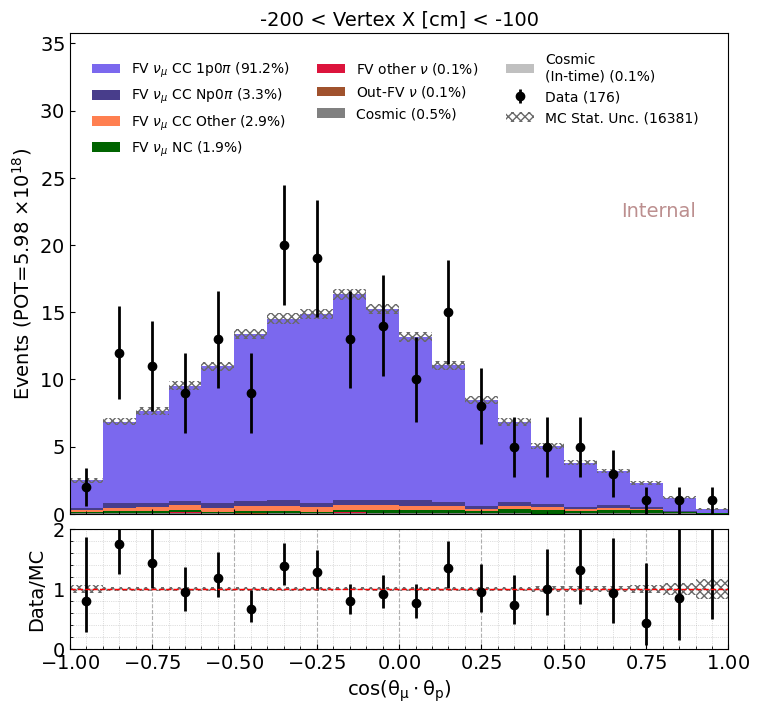

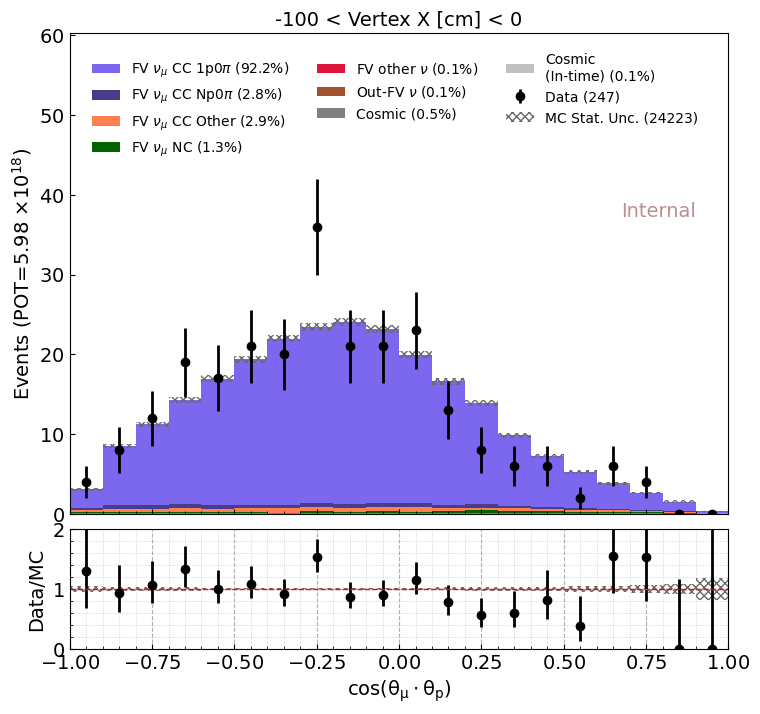

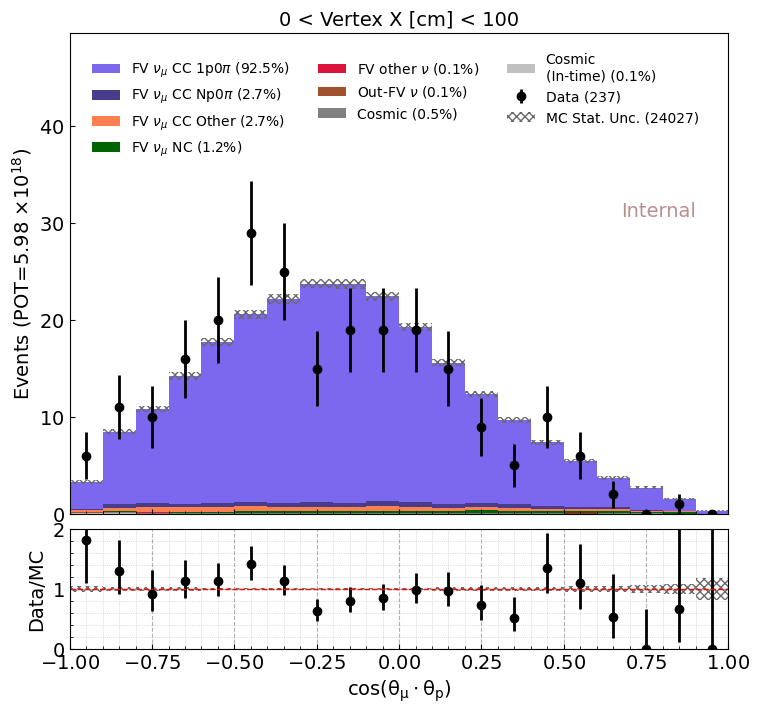

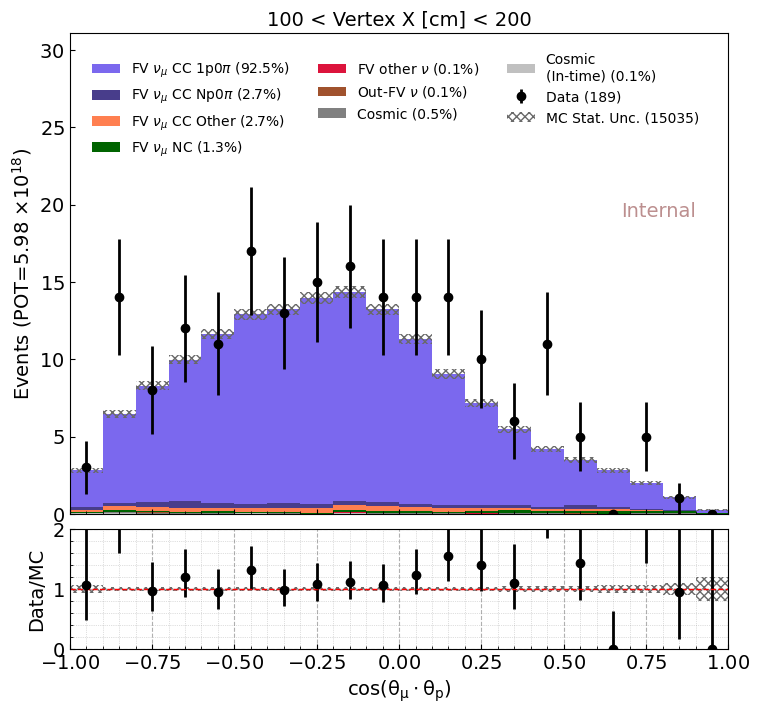

In [ ]:
# opening angle
mcdf = mc_mu_df #.reset_index(level=[3])
pudf = mc_p_df #.reset_index(level=[3])
vardf = mcdf.pfp.trk.dir.x * pudf.pfp.trk.dir.x + mcdf.pfp.trk.dir.y * pudf.pfp.trk.dir.y + mcdf.pfp.trk.dir.z * pudf.pfp.trk.dir.z
data_mudf = data_mu_df #.reset_index(level=[3])
data_pdf = data_p_df #.reset_index(level=[3])
vardf_data = data_mudf.pfp.trk.dir.x * data_pdf.pfp.trk.dir.x + data_mudf.pfp.trk.dir.y * data_pdf.pfp.trk.dir.y + data_mudf.pfp.trk.dir.z * data_pdf.pfp.trk.dir.z
intime_mcdf = intime_mu_df #.reset_index(level=[3])
intime_pudf = intime_p_df #.reset_index(level=[3])
vardf_intime = intime_mcdf.pfp.trk.dir.x * intime_pudf.pfp.trk.dir.x + intime_mcdf.pfp.trk.dir.y * intime_pudf.pfp.trk.dir.y + intime_mcdf.pfp.trk.dir.z * intime_pudf.pfp.trk.dir.z
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu} \cdot \theta_p)}$", 
               "Events (POT={})".format(pot_str), ""]

z_bins = [-200, -100, 0, 100, 200]

for i in range(len(z_bins)-1):
    z_min = z_bins[i]
    z_max = z_bins[i+1]
    plot_labels[2] = "{} < Vertex X [cm] < {}".format(z_min, z_max)

    mc_mask = (mc_evt_df_mup.slc.vertex.x > z_min) & (mc_evt_df_mup.slc.vertex.x < z_max)
    this_evtdf = mc_evt_df_mup[mc_mask]
    this_vardf = vardf[mc_mask]
    data_mask = (data_evt_df_mup.slc.vertex.x > z_min) & (data_evt_df_mup.slc.vertex.x < z_max)
    this_vardf_data = vardf_data[data_mask]
    intime_mask = (intime_evt_df_mup.slc.vertex.x > z_min) & (intime_evt_df_mup.slc.vertex.x < z_max)
    this_vardf_intime = vardf_intime[intime_mask]

    plot_type = "topology"
    save_name = save_fig_dir + f"/mu_p_opening_angle_{}_vertex_x_{}_{}.png".format(plot_type, z_min, z_max)
    ret_hist_topo = hist_plot(plot_type,
                            this_evtdf, this_vardf, 
                            this_vardf_data, this_vardf_intime,
                            bins, 
                            plot_labels,
                            save_fig=save_fig, save_name=save_name)

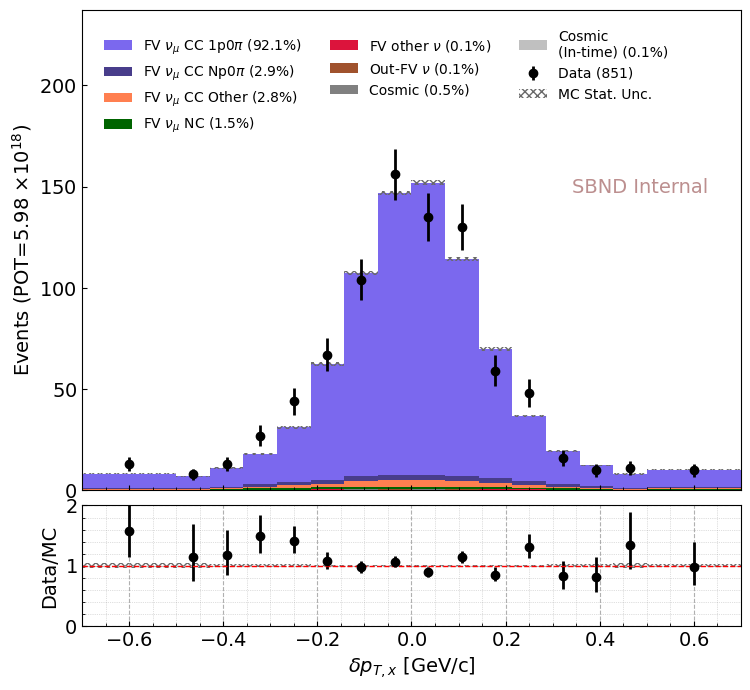

numu NC 1176


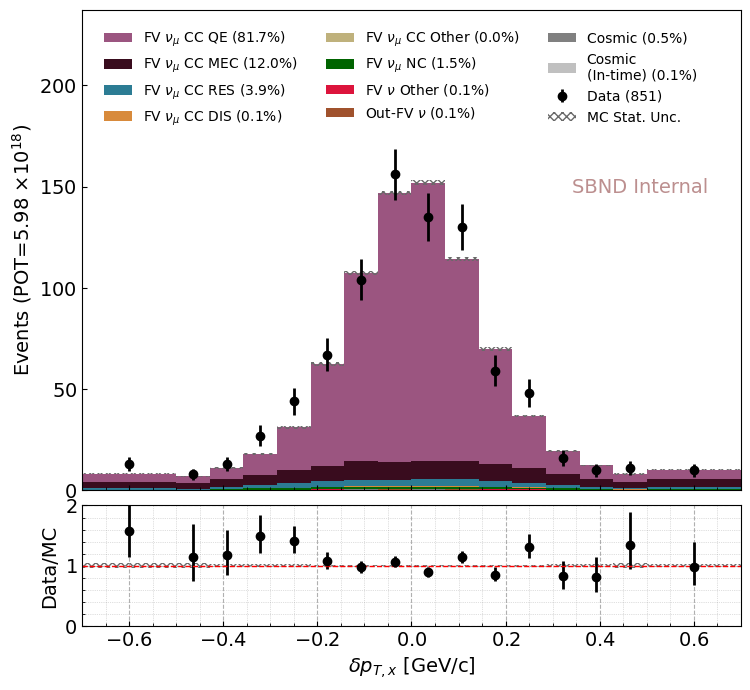

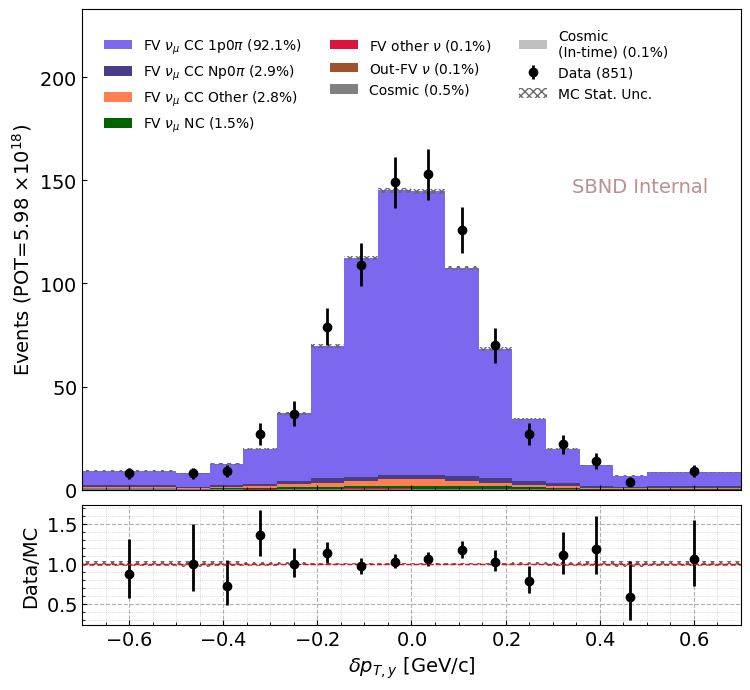

numu NC 1176


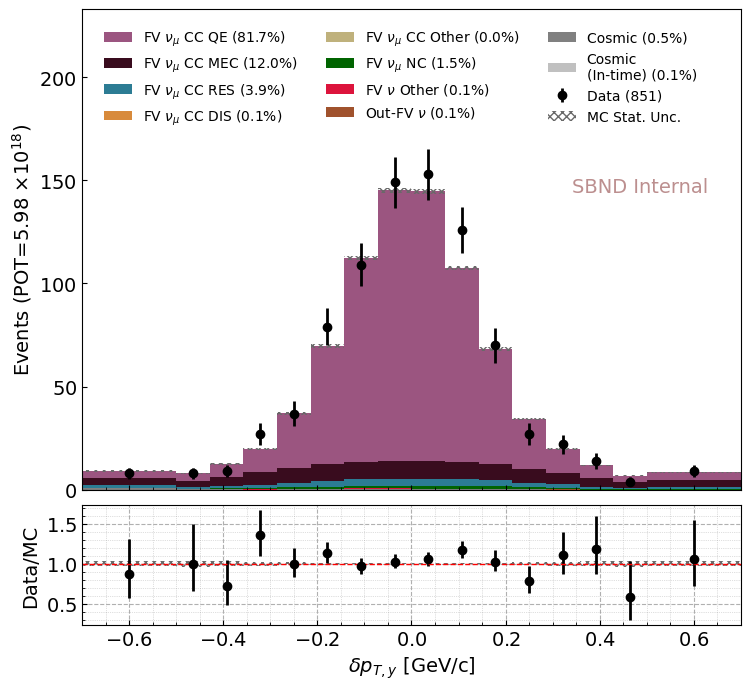

In [74]:
# delta p_x, delta p_y
evtdf = mc_evt_df
tki_name = "del_Tp_x"
var_config = VariableConfig.tki_del_Tp_x()
vardf = evtdf[tki_name]
vardf_data = data_evt_df[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
bins = [-0.7] + list(np.linspace(-0.5,0.5,15)) + [0.7]
bins = np.array(bins)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_{T,x}$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df
tki_name = "del_Tp_y"
var_config = VariableConfig.tki_del_Tp_y()
vardf = evtdf[tki_name]
vardf_data = data_evt_df[tki_name]
vardf_intime = intime_ret_tki[tki_name]
# bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_{T,y}$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


In [75]:
# Q2
# evtdf = mc_evt_df_mup

In [ ]:
# W

In [ ]:
# E_cal

## Kinematic Reconstruction

### Vertex Position

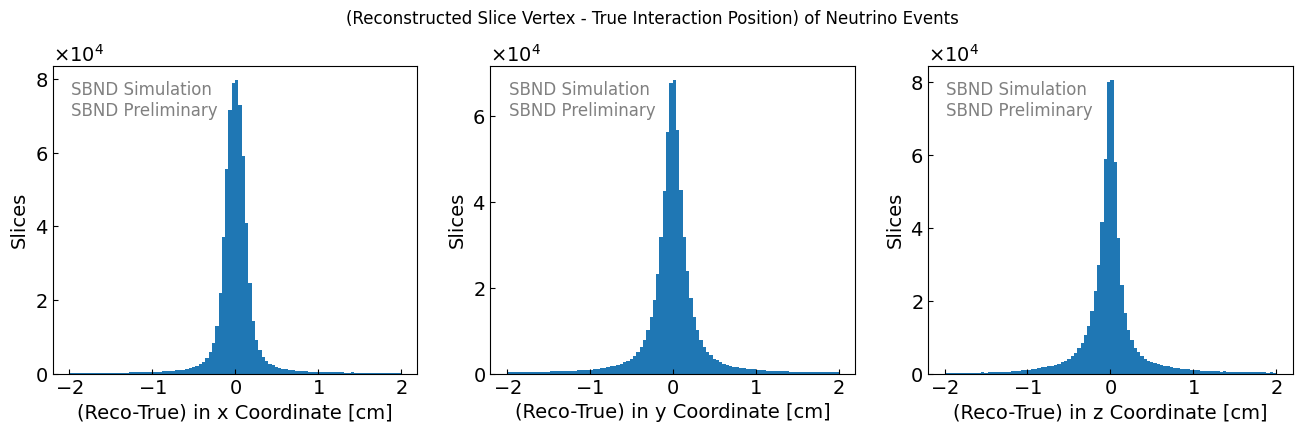

In [ ]:
# vertex reconstruction performance for neutrino slices
fig, axs = plt.subplots(1,3, figsize=(16,4))
for i, axis in enumerate(["x", "y", "z"]):
    var = mc_evt_df[IsNu(mc_evt_df)].slc.vertex[axis] - mc_evt_df[IsNu(mc_evt_df)].slc.truth.position[axis]
    bins = np.linspace(-2, 2, 101)
    # bins = 100
    axs[i].hist(var, bins=bins)
    axs[i].set_xlabel("(Reco-True) in {} Coordinate [cm]".format(axis))
    axs[i].set_ylabel("Slices")
    axs[i].text(0.05, 0.95, "SBND Simulation\nSBND Preliminary", fontsize=12, transform=axs[i].transAxes, 
                color="gray", ha="left", va="top")

plt.suptitle("(Reconstructed Slice Vertex - True Interaction Position) of Neutrino Events", y=1.02)
save_name = save_fig_dir + "/vertex_reco_res_3d.png"
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

### Momentum

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox

In [ ]:
mc_mu_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_mu_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
mc_p_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_p_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
mc_mu_df[("pfp", "trk", "truth", "p", "dir", "z")] = mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")] / mc_mu_df[("pfp", "trk", "truth", "p", "totp")]
mc_p_df[("pfp", "trk", "truth", "p", "dir", "z")] = mc_p_df[("pfp", "trk", "truth", "p", "genp", "z")] / mc_p_df[("pfp", "trk", "truth", "p", "totp")]

/tmp/ipykernel_1976885/1301984053.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_mu_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
/tmp/ipykernel_1976885/1301984053.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_p_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_p_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
/tmp/ipykernel_1976885/1301984053.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_df[("pfp", "trk", "truth", "p", "dir", "z")] = mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")] / mc_mu_df[("pfp", "trk", "truth", "p", "totp")]
/tmp/ipykernel_1976885/1301984053.py:4: Perfor

In [ ]:
mc_mu_df.pfp.trk.truth.p

start_process end_process  pdg    startE  \
                                                                         
                                                                         
__ntuple entry rec.slc..index                                            
21       6597  1                          0          41   13  0.966251   
321      4632  0                          0          41   13  1.038099   
109      17098 1                          0          41   13  0.963152   
387      2116  0                          0          41   13  0.970958   
235      15079 0                          0          41   13  0.983693   
...                                     ...         ...  ...       ...   
229      15032 0                          0          41   13  0.240690   
268      5269  1                          0          45 -211  0.291720   
7        4686  0                          0          41   13  0.250385   
273      1348  2                          0          41   13  0.246573   
252      3577  0                          0          41   13  0.245668   

                                    start                                 end  \
                                        x           y           z           x   
                                                                                
__ntuple entry rec.slc..index                                                   
21       6597  1                85.915092 -111.882736   32.049911 -111.713020   
321      4632  0               -82.252304  -42.302498  109.820915  162.969193   
109      17098 1               133.328674  -86.300209  110.207977  -69.007759   
387      2116  0               -13.049406  -44.390472   16.630436  -78.574196   
235      15079 0                98.603752  -20.419470   26.926506  -82.459206   
...                                   ...         ...         ...         ...   
229      15032 0              -148.371918  165.987900  170.104752 -149.359344   
268      5269  1                34.197502  -11.495999  137.161407   81.183884   
7        4686  0               121.957039  -60.237457   93.585144   85.101440   
273      1348  2               107.838997 -155.334885  103.154282  143.147522   
252      3577  0               -50.068359   84.426216  433.642487  -40.638680   

                                                       ...      length  \
                                        y           z  ...               
                                                       ...               
__ntuple entry rec.slc..index                          ...               
21       6597  1                20.323870  347.435211  ...  398.122192   
321      4632  0               -26.392782  419.090485  ...  396.886047   
109      17098 1               -21.229210  427.602112  ...  384.551880   
387      2116  0                -3.285330  405.192566  ...  397.391907   
235      15079 0                42.777641  372.722900  ...  397.356812   
...                                   ...         ...  ...         ...   
229      15032 0               146.300797  212.508652  ...   46.761608   
268      5269  1                 6.465998  134.749161  ...   50.577518   
7        4686  0               -89.610466  106.534317  ...   49.281521   
273      1348  2              -123.909485  109.244118  ...   47.658516   
252      3577  0                37.838741  448.445251  ...   49.783863   

                                   G4ID    parent cont_tpc      genE  \
                                                                       
                                                                       
__ntuple entry rec.slc..index                                          
21       6597  1               10000002  10000000        0  0.966251   
321      4632  0               10000001  10000000        0  1.038099   
109      17098 1               10000001  10000000        0  0.963152   
387      2116  0               10000001  10000000        1  0.970958   
235      15079 0

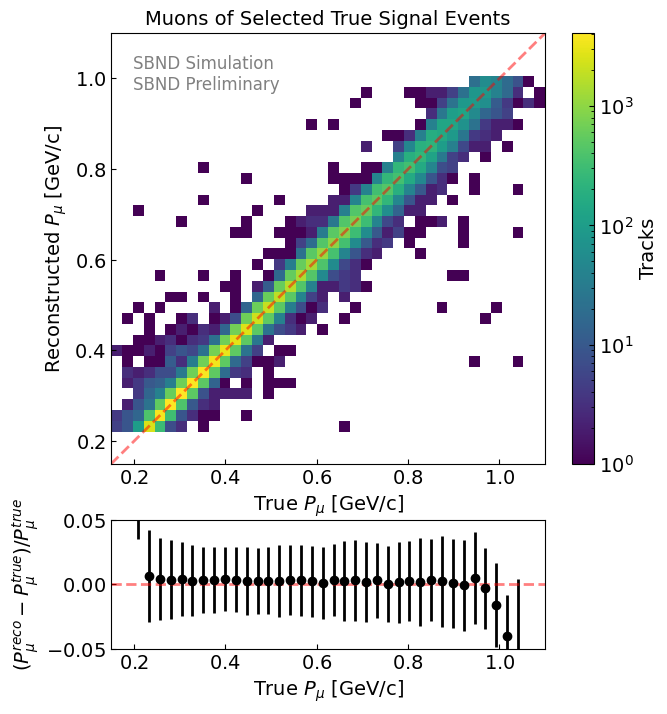

In [ ]:
var_true = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.totp
var_reco = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.rangeP.p_muon
plot_labels = ["True $P_{\\mu}$ [GeV/c]", "Reconstructed $P_{\\mu}$ [GeV/c]", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{\\mu}^{reco} - P_{\\mu}^{true}) / P_{\\mu}^{true}$"]
bins = np.linspace(0.15, 1.1, 41)
bins_frac = np.linspace(-0.1, 0.1, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_true, var_reco, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
ax[0].text(0.05, 0.95, "SBND Simulation\nSBND Preliminary", fontsize=12, transform=ax[0].transAxes, 
            color="gray", ha="left", va="top")
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_true > bins[i]) & (var_true < bins[i+1])
    # this_diff = (var_true[this_cut] - var_reco[this_cut])/var_reco[this_cut]
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])
ax[1].set_ylim(-0.05, 0.05)

save_name = save_fig_dir + "/kin_true-P_res-mu_rangeP_mu_candidate.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

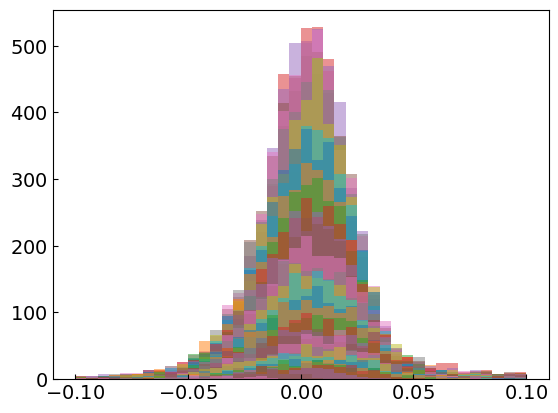

In [ ]:
var_reco = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.rangeP.p_muon
var_true = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.totp
bins = np.linspace(0.2, 1.1, 41)
bins_frac = np.linspace(-0.1, 0.1, 41)

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_true > bins[i]) & (var_true < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -1, 1)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2

In [ ]:
# var_reco = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.rangeP.p_proton
# var_true = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.truth.p.totp
# plot_labels = ["Reconstructed $P_{p}$ [GeV/c]", "True $P_{p}$ [GeV/c]", "Protons of Selected True Signal Events"]
# plot_labels_frac = ["$(P_{p}^{reco} - P_{p}^{true}) / P_{p}^{true}$"]
# bins = np.linspace(0.15, 1.2, 41)

# fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

# im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
# ax[0].set_xlabel(plot_labels[0])
# ax[0].set_ylabel(plot_labels[1])
# ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
# ax[0].set_title(plot_labels[2])
# plt.colorbar(im[3], ax=ax[0], label="Tracks")

# mean_list = []
# sig_list = []
# for i in range(len(bins)-1):
#     this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
#     this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
#     this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
#     this_diff = np.clip(this_diff, -0.2, 0.2)
#     mean_list.append(np.median(this_diff))
#     sig_list.append(np.std(this_diff))
# bin_centers = (bins[:-1] + bins[1:])/2
# ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# # Match the size and position of the lower subplot to the upper subplot

# # Set x-limits to match
# ax[1].set_xlim(ax[0].get_xlim())

# # Match subplot width and position
# pos0 = ax[0].get_position()
# pos1 = ax[1].get_position()
# ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
# ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
# ax[1].set_xlabel(plot_labels[0])
# ax[1].set_ylabel(plot_labels_frac[0])

# save_name = save_fig_dir + "/kin_reco-P_res-p_rangeP.pdf"
# if save_fig:
#     plt.savefig(save_name, bbox_inches="tight")
# plt.show();

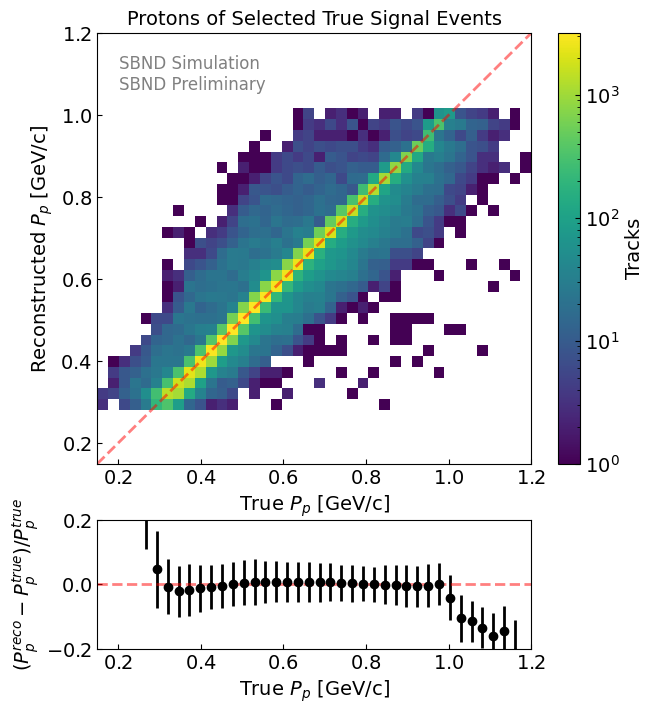

In [ ]:
var_true = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.truth.p.totp
var_reco = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.rangeP.p_proton
plot_labels = ["True $P_{p}$ [GeV/c]", "Reconstructed $P_{p}$ [GeV/c]", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{p}^{reco} - P_{p}^{true}) / P_{p}^{true}$"]
bins = np.linspace(0.15, 1.2, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_true, var_reco, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
ax[0].text(0.05, 0.95, "SBND Simulation\nSBND Preliminary", fontsize=12, transform=ax[0].transAxes, 
            color="gray", ha="left", va="top")
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_true > bins[i]) & (var_true < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.4, 0.4)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])
ax[1].set_ylim(-0.2, 0.2)

save_name = save_fig_dir + "/kin_true-P_res-p_rangeP.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

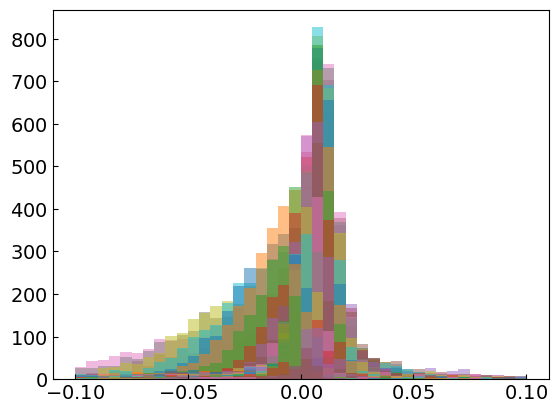

In [ ]:
var_reco = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.rangeP.p_proton
var_true = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.truth.p.totp
bins = np.linspace(0.2, 1.1, 41)
bins_frac = np.linspace(-0.1, 0.1, 41)

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_true > bins[i]) & (var_true < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -1, 1)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))

### Direction

In [ ]:
import statsmodels.api as sm

def eff_err(success,total):  # success/total
    err = [[],[]]
    eff = success/total
    for i in range(len(success)):
        this_success = success[i]
        this_tot = total[i]
        interval = sm.stats.proportion_confint(this_success,this_tot,method='wilson')
        err[0].append(abs(eff[i]-interval[0]))
        err[1].append(abs(eff[i]-interval[1]))
    return err

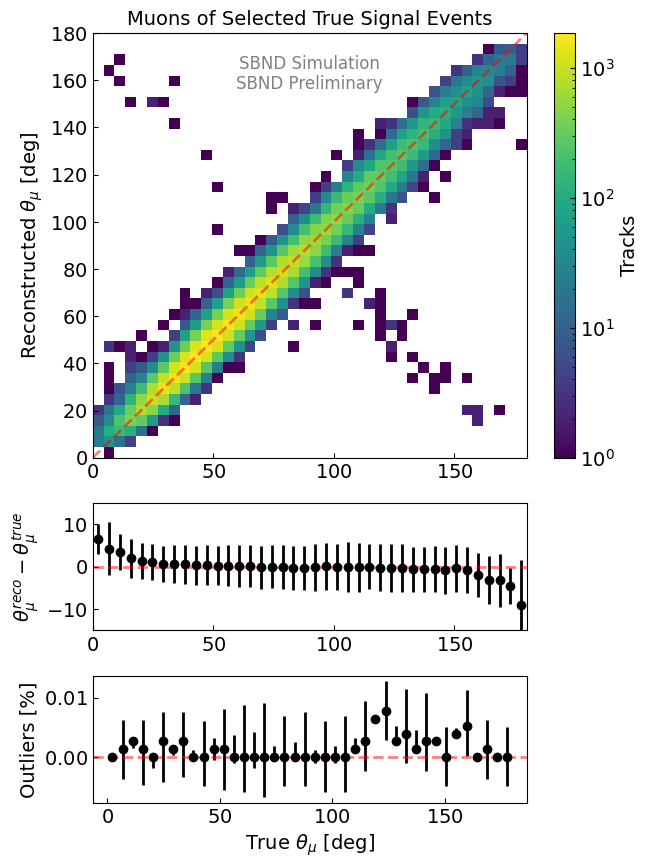

In [ ]:
var_reco = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.dir.z) * 180/np.pi
var_true = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.dir.z) * 180/np.pi
plot_labels = ["True $\\theta_{\\mu}$ [deg]", "Reconstructed $\\theta_{\\mu}$ [deg]", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$\\theta_{\\mu}^{reco} - \\theta_{\\mu}^{true}$"]
# bins = np.linspace(0, np.pi, 41)
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(3,1, figsize=(7,10), height_ratios=[4,1.2,1.2])

im = ax[0].hist2d(var_true, var_reco, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
# ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
ax[0].text(0.5, 0.95, "SBND Simulation\nSBND Preliminary", fontsize=12, transform=ax[0].transAxes, 
            color="gray", ha="center", va="top")
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
flipped_list = []
flipped_err = []
for i in range(len(bins)-1):
    this_cut = (var_true > bins[i]) & (var_true < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    # exclude flipped tracks: subtract 90, check signs
    is_flipped = ( np.abs(var_reco[this_cut] - var_true[this_cut]) > 45)
    flipped_perc = np.sum(is_flipped) / len(this_cut)
    flipped_list.append(flipped_perc)
    this_flipped_err = eff_err(np.array([np.sum(is_flipped)]), np.array([len(this_cut)]))
    flipped_err.append(this_flipped_err)
    this_diff = this_diff[~is_flipped]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    # this_diff = np.clip(this_diff, -20, 20)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
# ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])
ax[1].set_ylim(-15, 15)

ax[2].errorbar(bin_centers, np.array(flipped_list)*100, yerr=np.array(flipped_err).reshape(2,40)*100, fmt="o", color="black")
# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[2].get_position()
ax[2].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[2].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[2].set_xlabel(plot_labels[0])
ax[2].set_ylabel("Outliers [%]")

save_name = save_fig_dir + "/kin_reco-thetaz_res-mu.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


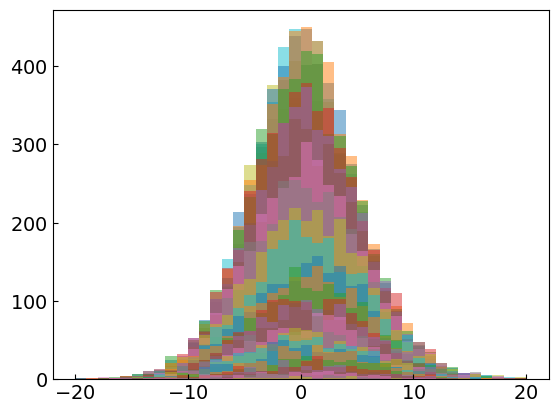

In [ ]:
var_reco = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.dir.z) * 180/np.pi
var_true = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.dir.z) * 180/np.pi
bins = np.linspace(0, 180, 41)
bins_frac = np.linspace(-20, 20, 41)

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -1, 1)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))

In [ ]:
save_fig_dir

'/exp/sbnd/data/users/munjung/plots/numucc1p0pi/data_vs_mc'

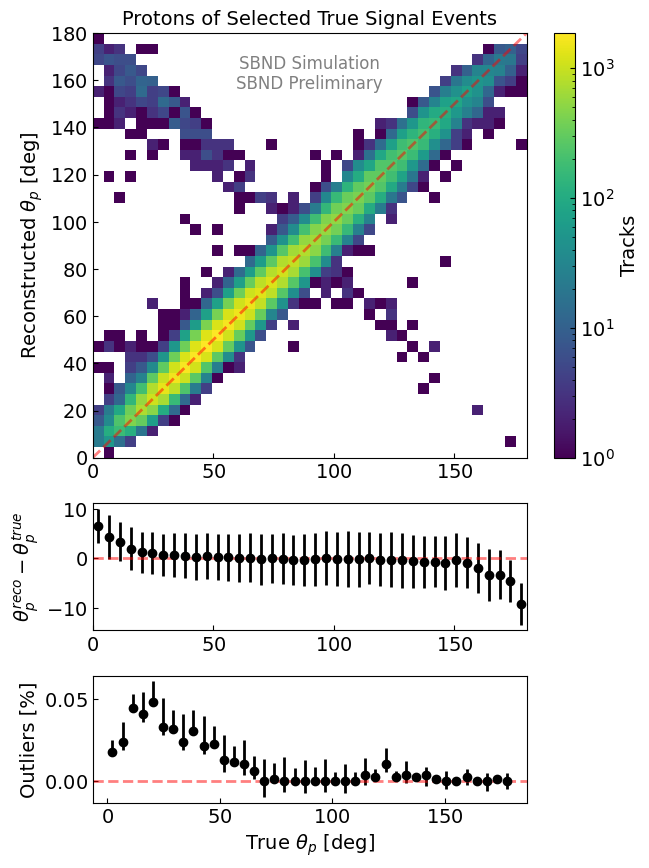

In [ ]:
var_reco = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t1.pfp.trk.dir.z) * 180/np.pi
var_true = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t1.pfp.trk.truth.p.dir.z) * 180/np.pi
plot_labels = ["True $\\theta_{p}$ [deg]", "Reconstructed $\\theta_{p}$ [deg]", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$\\theta_{p}^{reco} - \\theta_{p}^{true}$"]
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(3,1, figsize=(7,10), height_ratios=[4,1.2,1.2])

im = ax[0].hist2d(var_true, var_reco, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
# ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
ax[0].text(0.5, 0.95, "SBND Simulation\nSBND Preliminary", fontsize=12, transform=ax[0].transAxes, 
            color="gray", ha="center", va="top")
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
flipped_list = []
flipped_err = []
for i in range(len(bins)-1):
    this_cut = (var_true > bins[i]) & (var_true < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    is_flipped = ( np.abs(var_reco[this_cut] - var_true[this_cut]) > 45)
    flipped_perc = np.sum(is_flipped) / len(this_cut)
    flipped_list.append(flipped_perc)
    this_flipped_err = eff_err(np.array([np.sum(is_flipped)]), np.array([len(this_cut)]))
    flipped_err.append(this_flipped_err)
    this_diff = this_diff[~is_flipped]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -15, 15)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
# ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

ax[2].errorbar(bin_centers, np.array(flipped_list)*100, yerr=np.array(flipped_err).reshape(2,40)[::-1]*100, fmt="o", color="black")
# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[2].get_position()
ax[2].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[2].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[2].set_xlabel(plot_labels[0])
ax[2].set_ylabel("Outliers [%]")

save_name = save_fig_dir + "/kin_reco-thetaz_res-p.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


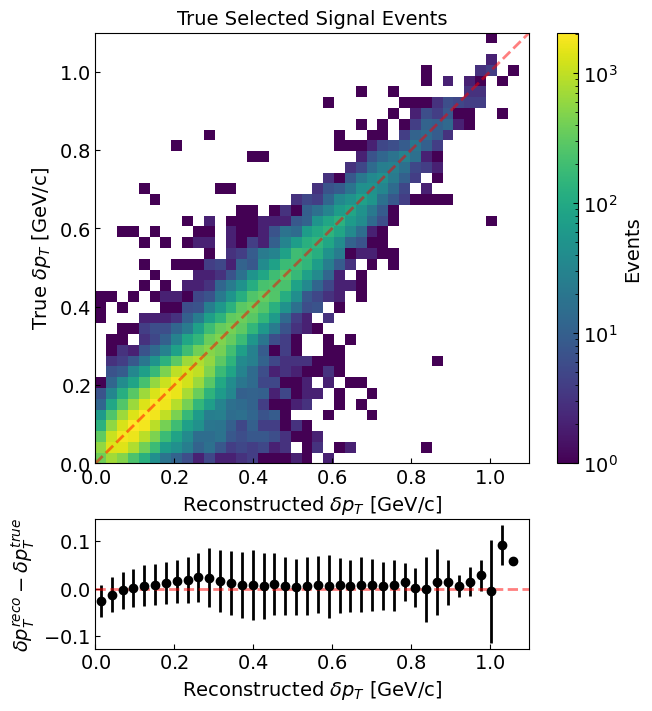

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_Tp
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_Tp
plot_labels = ["Reconstructed $\\delta p_T$ [GeV/c]", "True $\\delta p_T$ [GeV/c]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta p_T^{reco} - \\delta p_T^{true}$"]
bins = np.linspace(0, 1.1, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delTp_res.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

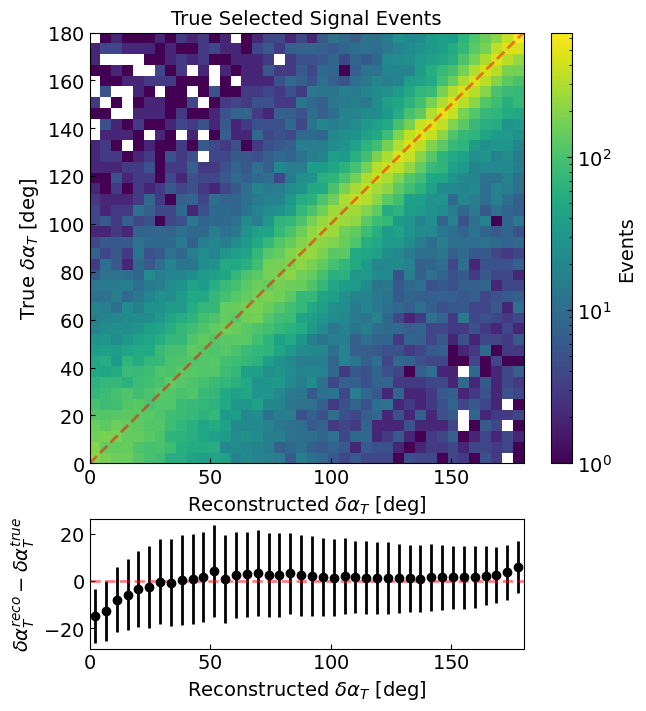

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_alpha 
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_alpha
plot_labels = ["Reconstructed $\\delta \\alpha_T$ [deg]", "True $\\delta \\alpha_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\alpha^{reco}_T - \\delta \\alpha^{true}_T$"]
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delalpha_res.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

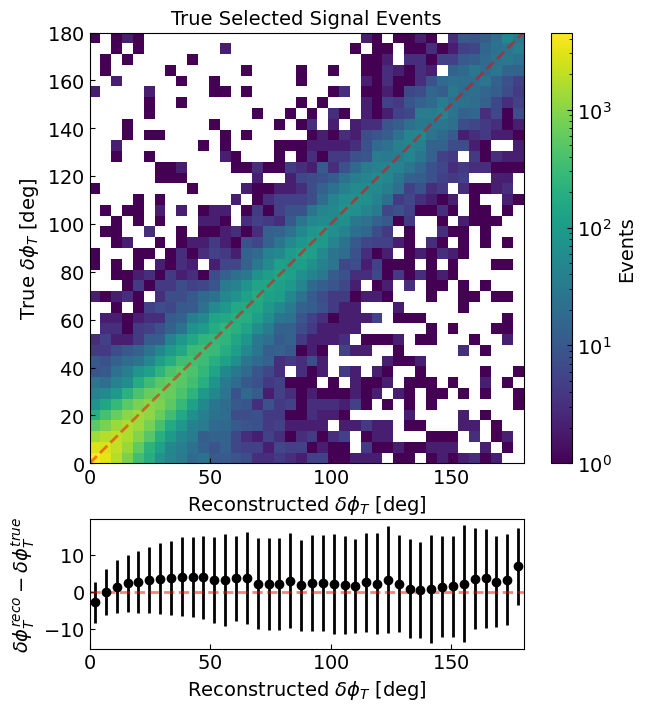

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi 
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi
plot_labels = ["Reconstructed $\\delta \\phi_T$ [deg]", "True $\\delta \\phi_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\phi^{reco}_T - \\delta \\phi^{true}_T$"]
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delalpha_res.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

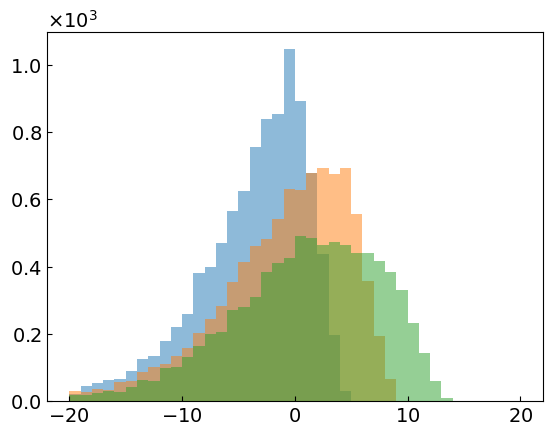

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi 
plot_labels = ["Reconstructed $\\delta \\phi_T$ [deg]", "True $\\delta \\phi_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\phi^{reco}_T - \\delta \\phi^{true}_T$"]
bins = np.linspace(0, 180, 41)
bins_frac = np.linspace(-20, 20, 41)

mean_list = []
sig_list = []
# for i in range(len(bins)-1):
for i in range(3):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)

    # this_diff = np.clip(this_diff, -1, 1)
    # mean_list.append(np.median(this_diff))
    # sig_list.append(np.std(this_diff))

### Resolution in Measurement Bins

In [ ]:
def percentage_in_diag(matrix):
    total = np.sum(matrix)
    diag = np.sum(np.diag(matrix))
    return diag/total

Fraction of events in the diagonal: 83.15


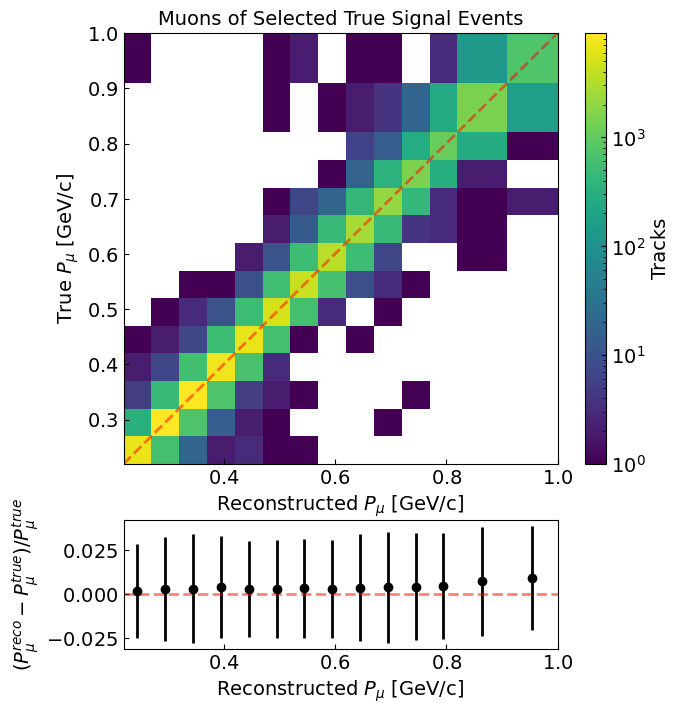

In [ ]:
var_config = VariableConfig.muon_momentum()
bins = var_config.bins
var_reco = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.rangeP.p_muon
var_true = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.truth.p.totp
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $P_{\\mu}$ [GeV/c]", "True $P_{\\mu}$ [GeV/c]", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{\\mu}^{reco} - P_{\\mu}^{true}) / P_{\\mu}^{true}$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-P_res-mu_rangeP_mu_candidate-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 77.44


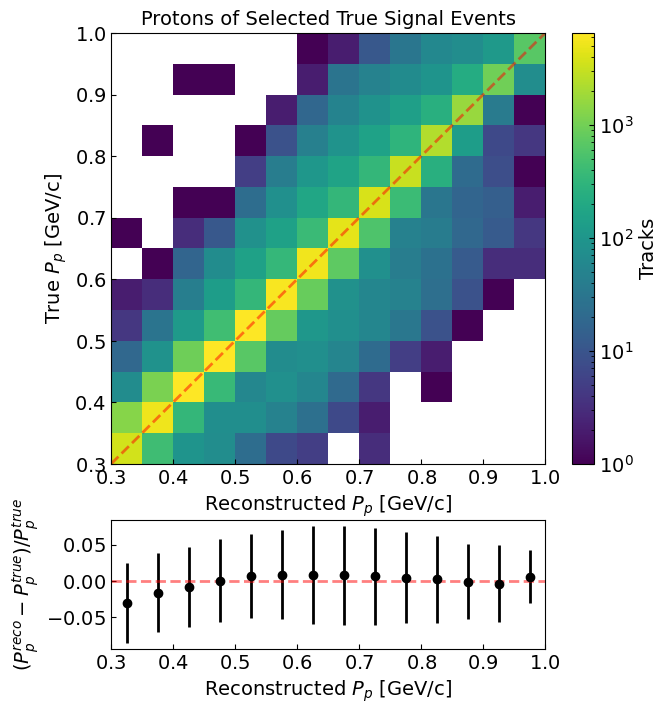

In [ ]:
var_config = VariableConfig.proton_momentum()
bins = var_config.bins

var_reco = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.rangeP.p_proton
var_true = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.truth.p.totp
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $P_{p}$ [GeV/c]", "True $P_{p}$ [GeV/c]", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{p}^{reco} - P_{p}^{true}) / P_{p}^{true}$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])
im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-P_res-p_rangeP_p_candidate-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

### Direction

Fraction of events in the diagonal: 61.10


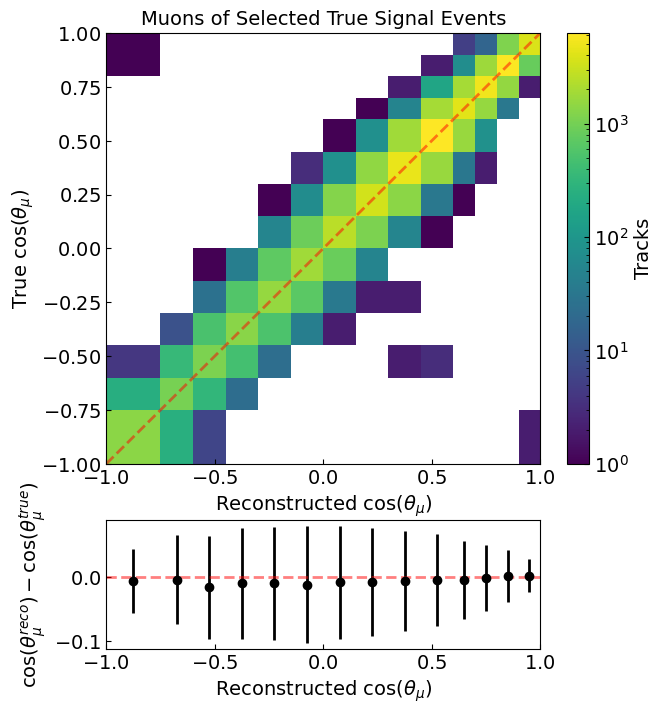

In [ ]:
var_config = VariableConfig.muon_direction()
bins = var_config.bins

var_reco = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.dir.z
var_true = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.truth.p.dir.z
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $\\cos (\\theta_{\\mu})$", "True $\\cos (\\theta_{\\mu})$", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$\\cos (\\theta_{\\mu}^{reco}) - \\cos (\\theta_{\\mu}^{true})$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-thetaz_res-mu-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 74.98


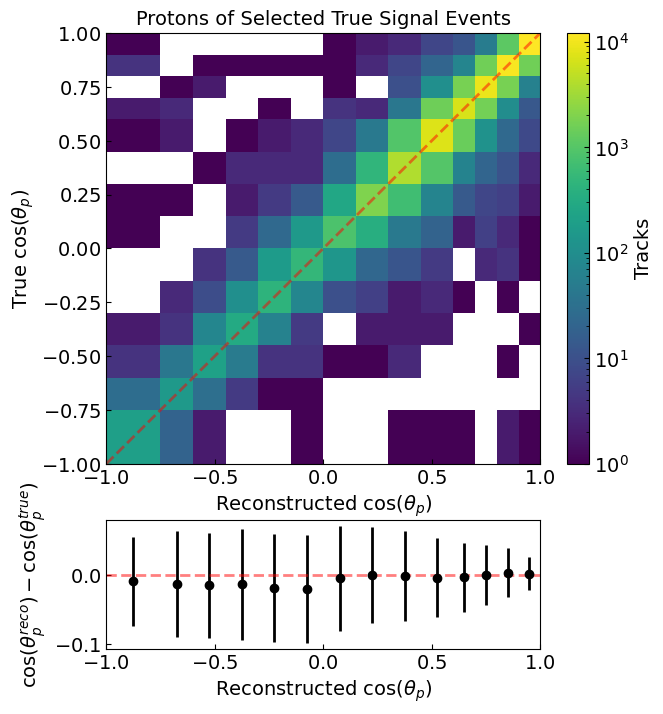

In [ ]:
var_config = VariableConfig.proton_direction()
bins = var_config.bins

var_reco = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.dir.z
var_true = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.truth.p.dir.z
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $\\cos (\\theta_{p})$", "True $\\cos (\\theta_{p})$", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$\\cos (\\theta_{p}^{reco}) - \\cos (\\theta_{p}^{true})$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-thetaz_res-p-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 44.97


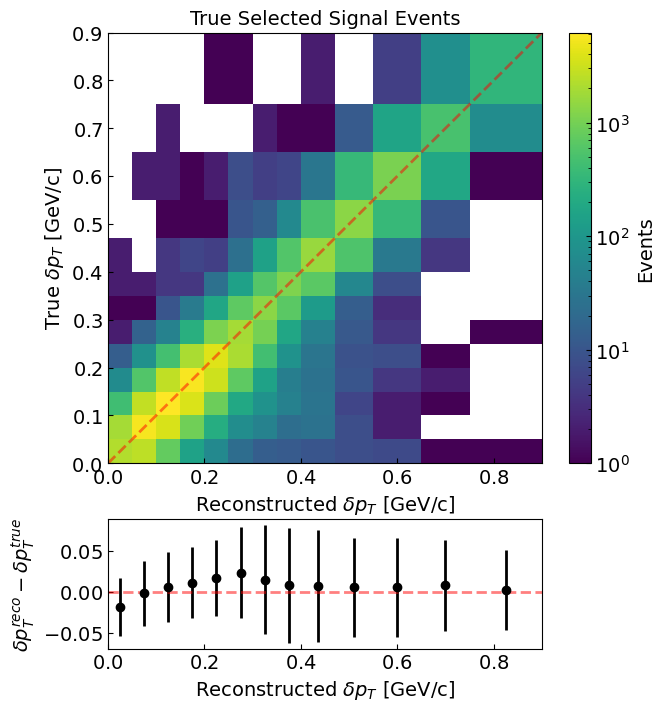

In [ ]:
var_config = VariableConfig.tki_del_Tp()
bins = var_config.bins

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_Tp
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_Tp
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $\\delta p_T$ [GeV/c]", "True $\\delta p_T$ [GeV/c]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta p_T^{reco} - \\delta p_T^{true}$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-delTp_res-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 56.59


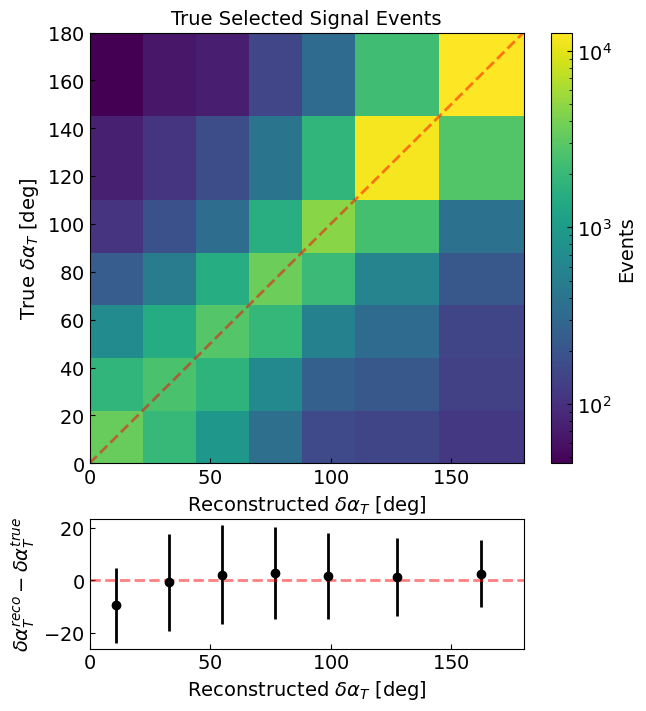

In [ ]:
var_config = VariableConfig.tki_del_alpha()
bins = var_config.bins

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_alpha
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_alpha
plot_labels = ["Reconstructed $\\delta \\alpha_T$ [deg]", "True $\\delta \\alpha_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\alpha^{reco}_T - \\delta \\alpha^{true}_T$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-delalpha_res-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 58.39


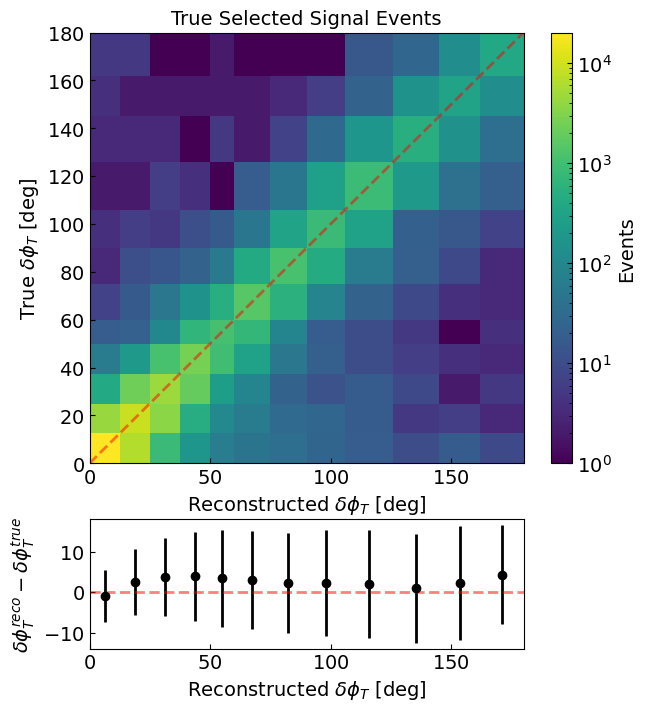

In [ ]:
var_config = VariableConfig.tki_del_phi()
bins = var_config.bins

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi
plot_labels = ["Reconstructed $\\delta \\phi_T$ [deg]", "True $\\delta \\phi_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\phi^{reco}_T - \\delta \\phi^{true}_T$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delphi_res-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

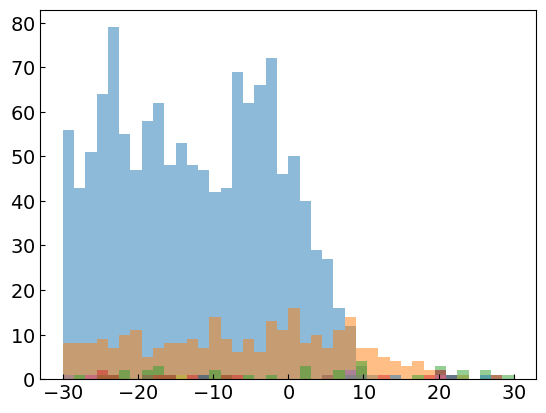

In [ ]:
var_config = VariableConfig.tki_del_phi()
bins = var_config.bins
bins_frac = np.linspace(-30, 30, 41)

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi * 180/np.pi
mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))

# Save fully selected df

In [ ]:
from pyanalib.pandas_helpers import *

In [ ]:
save_df = False

In [ ]:
mc_evt_df_mup
mc_mu_df
len(data_evt_df_mup) * 20 * 10

169800

In [ ]:
mc_mu_df.columns = pd.MultiIndex.from_tuples([tuple(["mu"] + list(c)) for c in mc_mu_df.columns])
mc_evt_df_mup = multicol_merge(mc_evt_df_mup, mc_mu_df, left_index=True, right_index=True, how="left", validate="one_to_one")

mc_p_df.columns = pd.MultiIndex.from_tuples([tuple(["p"] + list(c)) for c in mc_p_df.columns])
mc_evt_df_mup = multicol_merge(mc_evt_df_mup, mc_p_df, left_index=True, right_index=True, how="left", validate="one_to_one")

In [ ]:
mc_evt_df_mup.mu

genE      length   pdg      genp            \
                                                                  x         y   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
__ntuple entry rec.slc..index                                                   
21       6597  1               0.966251  398.122192  13.0 -0.495512  0.386841   
321      4632  0               1.038099  396.886047  13.0  0.581717  0.103263   
109      17098 1               0.963152  384.551880  13.0 -0.553427  0.178512   
387      2116  0               0.970958  397.391907  13.0 -0.173320  0.152298   
235      15079 0               0.983693  397.356812  13.0 -0.487013  0.166088   
..                                  ...         ...   ...       ...       ...   
229      15032 0               0.240690   46.761608  13.0  0.000927 -0.103276   
268      5269  1                    NaN         NaN   NaN       NaN       NaN   
7        4686  0               0.250385   49.281521  13.0 -0.177843 -0.125428   
273      1348  2               0.246573   47.658516  13.0  0.175074  0.136150   
252      3577  0               0.245668   49.783863  13.0  0.038671 -0.200805   

                                              start                          \
                                      z           x           y           z   
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
__ntuple entry rec.slc..index                                                 
21       6597  1               0.726154   85.915092 -111.882736   32.049911   
321      4632  0               0.847011  -82.252304  -42.302498  109.820915   
109      17098 1               0.760493  133.328674  -86.300209  110.207977   
387      2116  0               0.937209  -13.049406  -44.390472   16.630436   
235      15079 0               0.831697   98.603752  -20.419470   26.926506   
..                                  ...         ...         ...         ...   
229      15032 0               0.190003 -148.371918  165.987900  170.104752   
268      5269  1                    NaN         NaN         NaN         NaN   
7        4686  0               0.064566  121.957039  -60.237457   93.585144   
273      1348  2               0.021130  107.838997 -155.334885  103.154282   
252      3577  0               0.085854  -50.068359   84.426216  433.642487   

                                      end  ...          pfp            \
                                        x  ...          trk             
                                           ... is_contained         P   
                                           ...                 p_muon   
                                           ...                          
                                           ...                          
                                           ...                          
__ntuple entry rec.slc..index              ...                          
21       6597  1              -111.713020  ...         True  0.999872   
321      4632  0               162.969193  ...         True  0.999786   
109      17098 1               -69.007759  ...         True  0.999602   
387      2116  0               -78.574196  ...         True  0.999585   
235      15079 0               -82.459206  ...         True  0.999543   
..                                    ...  .

In [ ]:
# if save_df:
#     mc_evt_df_mup.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/MC_bnb_cosmics-final.df", key="evt_0")
#     mc_hdr_df.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/MC_bnb_cosmics-final.df", key="hdr_0")

# Get selected event metadata for hand scanning

## Get kinematics of some events

In [ ]:
topo_categ = get_int_category(mc_evt_df_mup)
topo_categ.value_counts()
# mc_evt_df_mup[topo_categ == 3][mult_colnames]

 1    73469
 2     2279
 3     2231
 4     1122
-1      390
 5       98
 0       77
Name: count, dtype: int64

In [ ]:
mult_colnames = ["nmu", "np", "npi", "npi0", "nmu_220MeVc", "np_300MeVc", "npi_70MeVc"]

In [ ]:
badkin_df = mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.nmu_220MeVc == 1) & (mc_evt_df_mup.np_300MeVc == 1) & (mc_evt_df_mup.npi_70MeVc == 0)]
# ((badkin_df.mu.totp < 0.220) | (badkin_df.mu.totp > 1)).sum()
# ((badkin_df.p.totp < 0.30) | (badkin_df.p.totp > 1)).sum()
(badkin_df.npi0 > 0).sum()

158

In [ ]:
mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.npi_70MeVc > 0)]
mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.npi0 > 1)].npi0

__ntuple  entry  rec.slc..index
298       5386   0                 2.0
Name: npi0, dtype: float64

In [ ]:
has_pic = mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.npi_70MeVc > 0) & (mc_evt_df_mup.genie_mode == 2)]
# has_pi0 = mc_evt_df_mup[mc_evt_df_mup.npi0 > 1]
mc_hdr_df.loc[has_pic.reset_index(level=[2]).index]
# mc_evt_df_mup.loc[has_pic.index].genie_mode.value_counts()

pot  first_in_subrun  ismc   run  subrun  ngenevt  \
__ntuple entry                                                               
108      12223  0.000000e+00                0     1  2262      77      100   
375      6462   0.000000e+00                0     1  2361      28      100   
130      15369  0.000000e+00                0     1  4408      46      100   
283      3351   0.000000e+00                0     1  2197      59      100   
227      15767  0.000000e+00                0     1  3160      62      100   
321      1445   0.000000e+00                0     1  2794      29      100   
177      3261   0.000000e+00                0     1   386      45      100   
77       8796   0.000000e+00                0     1  3112      82      100   
331      6499   0.000000e+00                0     1  4323      46      100   
199      2871   0.000000e+00                0     1  3587       2      100   
152      3102   1.477005e+15                1     1  3773       8      100   
264      13541  0.000000e+00                0     1  1075      47      100   
319      6318   0.000000e+00                0     1  3981      92      100   
355      16669  0.000000e+00                0     1  3938      51      100   
102      3472   0.000000e+00                0     1  3190      29      100   
115      3052   0.000000e+00                0     1  1066      44      100   
46       16525  0.000000e+00                0     1  3438      22      100   
350      11383  0.000000e+00                0     1  2166      85      100   
143      7044   0.000000e+00                0     1  4281      37      100   
20       11180  0.000000e+00                0     1  2699      70      100   
268      7119   0.000000e+00                0     1  3426      31      100   
54       13722  0.000000e+00                0     1  4027      93      100   
1        7900   0.000000e+00                0     1   282      96      100   
327      10989  0.000000e+00                0     1  3573      63      100   

                evt  proc   cluster  fno  noffbeambnb  
__ntuple entry                                         
108      12223   69     0  64543392    0          0.0  
375      6462    76     0  64609846    0          0.0  
130      15369   76     0  64547212    0          0.0  
283      3351     5     0  64588636    0          0.0  
227      15767   63     0  78914699    0          0.0  
321      1445    22     0  22483652    0          0.0  
177      3261    55     0  64564215    0          0.0  
77       8796    54     0  78879024    0          0.0  
331      6499    49     0  22495487    0          0.0  
199      2871    32     0  22487032    0          0.0  
152      3102     3     0  22529325    0          0.0  
264      13541   18     0  64535502    0          0.0  
319      6318    54     0  64561052    0          0.0  
355      16669   16     0  22504328    0          0.0  
102      3472    35     0  22541573    0          0.0  
115      3052    98     0  64531159    0          0.0  
46       16525   51     0  22485872    0          0.0  
350      11383   89     0  22505431    0          0.0  
143      7044    56     0  22623177    0          0.0  
20       11180    6     0  78856781    0          0.0  
268      7119     3     0  22511191    0          0.0  
54       13722   18     0  78926055    0          0.0  
1        7900    19     0  22480075    0          0.0  
327      10989   91     0  78933097    0          0.0

In [ ]:
meta = (3998, 67, 14)
this_evt = mc_hdr_df[(mc_hdr_df.run == meta[0]) & (mc_hdr_df.subrun == meta[1]) & (mc_hdr_df.evt == meta[2])]
this_evt

pot  first_in_subrun  ismc   run  subrun  ngenevt  evt  proc  \
__ntuple entry                                                                 
117      11360  0.0                0     1  3998      67      100   14     0   

                 cluster  fno  noffbeambnb  
__ntuple entry                              
117      11360  78912243    0          0.0

In [ ]:
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].mu.length)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].p.length)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].genie_mode)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].pdg)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].iscc)
# print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index][["nmu", "np", "npi", "npi0"]])
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index][mult_colnames])
mc_evt_df.reset_index(level=[2]).loc[this_evt.index] #.t1.pfp.trk.len

__ntuple  entry
117       11360    60.789013
Name: length, dtype: float32
__ntuple  entry
117       11360    4.617738
Name: length, dtype: float32
__ntuple  entry
117       11360    2.0
Name: genie_mode, dtype: float64
__ntuple  entry
117       11360    14.0
Name: pdg, dtype: float64
__ntuple  entry
117       11360    1.0
Name: iscc, dtype: float64
                nmu   np  npi npi0 nmu_220MeVc np_300MeVc npi_70MeVc
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
__ntuple entry                                                      
117      11360  1.0  1.0  1.

rec.slc..index             slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry                                                          
117      11360              1               0  100.055382  147.781525   

                                                                   ...  \
                           self    tmatch                producer  ...   
                         z            eff       pur  idx           ...   
                                                                   ...   
                                                                   ...   
                                                                   ...   
                                                                   ...   
                                                                   ...   
__ntuple entry                                                     ...   
117      11360  214.261841   92  0.833961  0.956946  0.0        0  ...   

                       p            ind mc_del_alpha  mc_del_phi mc_del_Tp  \
                     dir                                                     
                       y         z                                           
                                                                             
                                                                             
                                                                             
                                                                             
                                                                             
__ntuple entry                                                               
117      11360  0.202857  0.977887  0.0   177.400436  171.653152  0.253169   

                mc_del_p mc_del_Tp_x mc_del_Tp_y pot_weight  
                                                             
                                                             
                                                             
                                                             
                                                             
                                                             
                                                             
__ntuple entry                                               
117      11360  0.375676    0.085846     0.23817   0.010203  

[1 rows x 324 columns]

In [ ]:
colnames = ["run", "subrun", "evt"]

## MC

In [ ]:
topo_categ = get_int_category(mc_evt_df_mup)
topo_categ.value_counts()

# genie_categ = get_genie_category(mc_evt_df_mup)
# genie_categ.value_counts()

 1    73469
 2     2279
 3     2231
 4     1122
-1      390
 5       98
 0       77
Name: count, dtype: int64

In [ ]:
save_meta = False

In [ ]:
if save_meta:
    # signal
    signal_meta = mc_hdr_df.loc[topo_categ[topo_categ == 1].reset_index(level=[2]).index][colnames]
    signal_meta.to_csv("signal_meta.csv", index=False)

    # cosmic
    cosmic_meta = mc_hdr_df.loc[topo_categ[topo_categ == -1].reset_index(level=[2]).index][colnames]
    cosmic_meta.to_csv("cosmic_meta.csv", index=False)

    # nu out of FV
    nu_outfv_meta = mc_hdr_df.loc[topo_categ[topo_categ == 0].reset_index(level=[2]).index][colnames]
    nu_outfv_meta.to_csv("nu_outfv_meta.csv", index=False)

    # numu cc np0pi
    numucc_np0pi_meta = mc_hdr_df.loc[topo_categ[topo_categ == 2].reset_index(level=[2]).index][colnames]
    numucc_np0pi_meta.to_csv("numucc_np0pi_meta.csv", index=False)

    # numu cc other
    numucc_other_meta = mc_hdr_df.loc[topo_categ[topo_categ == 3].reset_index(level=[2]).index][colnames]
    numucc_other_meta.to_csv("numucc_other_meta.csv", index=False)

    # numu nc
    numucc_nc_meta = mc_hdr_df.loc[topo_categ[topo_categ == 4].reset_index(level=[2]).index][colnames]
    numucc_nc_meta.to_csv("numucc_nc_meta.csv", index=False)

    # nu other
    nu_other_meta = mc_hdr_df.loc[topo_categ[topo_categ == 5].reset_index(level=[2]).index][colnames]
    nu_other_meta.to_csv("nu_other_meta.csv", index=False)

## Data

In [ ]:
data_meta = data_hdr_df.loc[data_evt_df_mup.reset_index(level=[2]).index][colnames]
data_meta.to_csv("data_meta.csv", index=False)

# Event Breakdown

In [ ]:
# final state topology detailed breakdown
this_df = mc_evt_df_mup[IsNuInFV_NumuCC_Np0pi(mc_evt_df_mup)]
this_df = mc_evt_df_mup[IsNuInFV_NumuCC_Other(mc_evt_df_mup)]
print(len(this_df))
this_df[["nmu_220MeVc", "np_300MeVc", "npi_70MeVc", "npi0"]]
# get unique combinations of nmu_27MeV, np_50MeV, npi_30MeV, npi0 and count how many events have each combination
unique_combinations = this_df[["nmu_220MeVc", "np_300MeVc", "npi_70MeVc", "npi0"]].drop_duplicates()
unique_combinations_list = []
for i in unique_combinations.index:
    nmu_27MeV_val = unique_combinations.loc[i].nmu_220MeVc
    np_50MeV_val = unique_combinations.loc[i].np_300MeVc
    npi_30MeV_val = unique_combinations.loc[i].npi_70MeVc
    npi0_val = unique_combinations.loc[i].npi0
    unique_combinations_list.append((int(nmu_27MeV_val), int(np_50MeV_val), int(npi_30MeV_val), int(npi0_val)))
print(len(unique_combinations_list), "unique combinations")

# count how many events have each combination
perc_list = []
for uc in unique_combinations_list:
    n_this_type = len(this_df[(this_df.nmu_220MeVc == uc[0]) & (this_df.np_300MeVc == uc[1]) & (this_df.npi_70MeVc == uc[2]) & (this_df.npi0 == uc[3])])
    perc = n_this_type/len(mc_evt_df_mup)
    print(uc, perc*100, n_this_type)
    perc_list.append(perc)
print(perc_list)
print(sum(perc_list))

2231
25 unique combinations
(1, 1, 0, 0) 1.2188386513694676 971
(1, 1, 1, 0) 0.37280646699972386 297
(1, 0, 0, 0) 0.46945999548113376 374
(1, 2, 1, 0) 0.028870534481460097 23
(1, 1, 0, 1) 0.19707277885170588 157
(1, 0, 1, 0) 0.19205181633319107 153
(1, 2, 0, 1) 0.017573368814801798 14
(0, 2, 0, 0) 0.021339090703687898 17
(0, 1, 1, 0) 0.027615293851831396 22
(1, 0, 0, 1) 0.0025104812592573996 2
(0, 4, 1, 0) 0.0012552406296286998 1
(0, 1, 0, 0) 0.20711470388873549 165
(1, 2, 2, 0) 0.0012552406296286998 1


/tmp/ipykernel_1976885/4290504341.py:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  unique_combinations_list.append((int(nmu_27MeV_val), int(np_50MeV_val), int(npi_30MeV_val), int(npi0_val)))


(1, 1, 1, 1) 0.0025104812592573996 2
(0, 0, 1, 0) 0.018828609444430496 15
(1, 1, 0, 2) 0.0012552406296286998 1
(1, 0, 2, 0) 0.0037657218888861 3
(0, 1, 0, 1) 0.0037657218888861 3
(1, 3, 1, 0) 0.0025104812592573996 2
(1, 0, 1, 1) 0.0012552406296286998 1
(1, 3, 0, 1) 0.0012552406296286998 1
(0, 2, 2, 0) 0.0012552406296286998 1
(0, 2, 1, 0) 0.0037657218888861 3
(0, 1, 2, 0) 0.0012552406296286998 1
(0, 0, 0, 0) 0.0012552406296286998 1
[0.012188386513694676, 0.0037280646699972384, 0.0046945999548113375, 0.00028870534481460097, 0.0019707277885170587, 0.0019205181633319107, 0.00017573368814801797, 0.00021339090703687897, 0.00027615293851831395, 2.5104812592573997e-05, 1.2552406296286999e-05, 0.002071147038887355, 1.2552406296286999e-05, 2.5104812592573997e-05, 0.00018828609444430496, 1.2552406296286999e-05, 3.7657218888861e-05, 3.7657218888861e-05, 2.5104812592573997e-05, 1.2552406296286999e-05, 1.2552406296286999e-05, 1.2552406296286999e-05, 3.7657218888861e-05, 1.2552406296286999e-05, 1.255

In [ ]:
import pickle
with open("df_dict_2prong.pkl", "wb") as f:
    pickle.dump(df_dict, f)

In [ ]:
!pwd

/exp/sbnd/app/users/munjung/xsec/cafpyana/analysis_village/numucc1p0pi


In [ ]:
df_dict['2prong'].mc_del_Tp

__ntuple  entry  rec.slc..index
1         9      2                 0.459378
          27     1                 0.192884
          30     0                 0.251575
          32     1                 0.207835
          36     2                 0.105269
                                     ...   
389       16832  2                 0.134673
          16835  0                 0.446213
          16840  1                      NaN
          16850  1                 0.052390
          16852  0                 0.295102
Name: mc_del_Tp, Length: 939365, dtype: float32

In [ ]:
for k in df_dict_data.keys():
    print(len(df_dict_data[k]))

12949
3848
2412
1754
1274
849
